In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import lightgbm as lgb3

In [ ]:
# === Prétraitement commun ===

# 1. Chargement des données
df = pd.read_csv('/Users/faustin/Downloads/merged_datasets_with_events.csv', sep=',')

# 2. Conversion des colonnes de date
df['WORK_DATE'] = pd.to_datetime(df['WORK_DATE'])
df['DEB_TIME']  = pd.to_datetime(df['DEB_TIME'])

# 3. Création de nouvelles features temporelles
df['month']   = df['WORK_DATE'].dt.month
df['day']     = df['WORK_DATE'].dt.day
df['weekday'] = df['WORK_DATE'].dt.dayofweek
df['hour']    = df['DEB_TIME'].dt.hour
df['minute']  = df['DEB_TIME'].dt.minute

# 4. Filtrage hors période Covid
covid_start = pd.to_datetime('2020-03-01')
covid_stop  = pd.to_datetime('2022-01-01')
df = df[(df['WORK_DATE'] < covid_start) | (df['WORK_DATE'] > covid_stop)]

# 5. Encodage cyclique des variables temporelles
def encode_cyclic_feature(df, col, max_val):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df.drop(columns=[col])

df = encode_cyclic_feature(df, 'month', 12)
df = encode_cyclic_feature(df, 'day', 31)
df = encode_cyclic_feature(df, 'weekday', 7)
df = encode_cyclic_feature(df, 'hour', 24)
df = encode_cyclic_feature(df, 'minute', 60)

# 6. Suppression des colonnes non désirées
cols_to_drop = [
    'DEB_TIME_HOUR', 'NB_UNITS', 'GUEST_CARRIED', 
    'ADJUST_CAPACITY', 'NB_MAX_UNIT', 'temp', 'humidity', 
    'DEB_TIME', 'WORK_DATE', 'FIN_TIME', 'wind_speed', 
    'rain_1h', 'rain_3h', 'snow_1h', 'DOWNTIME', 'OPEN_TIME', 'CAPACITY'
]
cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop)

# 7. Encodage des variables catégorielles
categorical_cols = ['weather_description', 'REF_CLOSING_DESCRIPTION', 
                      'ENTITY_DESCRIPTION_SHORT', 'NIGHT_SHOW_FLAG', 'PARADE_FLAG']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category').cat.codes

# 8. Définition de la variable cible
target = 'WAIT_TIME_MAX'

# === Boucle pour entraîner un modèle par entité ===

# On récupère la liste des entités uniques
entities = df['ENTITY_DESCRIPTION_SHORT'].unique()

# Liste pour stocker les résultats
results = []

# Paramètres de LightGBM (identiques pour chaque entité)
params = {
    'objective':    'regression',
    'metric':       'mae',
    'boosting_type':'gbdt',
    'verbosity':    -1,
    'seed':         42
}

# Itération sur chaque entité
for entity in entities:
    # Filtrer le DataFrame pour l'entité en cours
    df_entity = df[df['ENTITY_DESCRIPTION_SHORT'] == entity].copy()
    
    # Vérifier que l'entité comporte suffisamment de données
    if len(df_entity) < 50:
        print(f"Skipping entity {entity} due to insufficient samples: {len(df_entity)} rows")
        continue
    
    # Définir les features : on retire la variable cible et 'ENTITY_DESCRIPTION_SHORT'
    features = [col for col in df_entity.columns if col not in [target, 'ENTITY_DESCRIPTION_SHORT']]
    
    # Définir X et y
    X = df_entity[features]
    y = df_entity[target]
    
    # Séparation en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Création des datasets pour LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data  = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Entraînement du modèle avec early stopping et log via callbacks
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
    )
    
    # Prédictions et évaluation
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    
    # Stocker les résultats
    results.append({
        "entity": entity,
        "n_samples": len(df_entity),
        "rmse": rmse,
        "mae": mae,
        "best_iteration": model.best_iteration
    })
    
# Convertir les résultats en DataFrame et les afficher
results_df = pd.DataFrame(results)
print(results_df)


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 4.02528
[200]	valid_0's l1: 3.86179
[300]	valid_0's l1: 3.77786
[400]	valid_0's l1: 3.72269
[500]	valid_0's l1: 3.68962
[600]	valid_0's l1: 3.66946
[700]	valid_0's l1: 3.65264
Early stopping, best iteration is:
[693]	valid_0's l1: 3.65192
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 5.86771
[200]	valid_0's l1: 5.45877
[300]	valid_0's l1: 5.19771
[400]	valid_0's l1: 5.00205
[500]	valid_0's l1: 4.86501
[600]	valid_0's l1: 4.75241
[700]	valid_0's l1: 4.66193
[800]	valid_0's l1: 4.59829
[900]	valid_0's l1: 4.54317
[1000]	valid_0's l1: 4.49409
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.49409
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 7.61766
[200]	valid_0's l1: 7.18192
[300]	valid_0's l1: 6.92649
[400]	valid_0's l1: 6.74912
[500]	valid_0's l1: 6.639
[600]	valid_0's l1: 6.54981
[700]	valid_0's l1: 6.48761
[800]	

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 4.02528
[200]	valid_0's l1: 3.86179
[300]	valid_0's l1: 3.77786
[400]	valid_0's l1: 3.72269
[500]	valid_0's l1: 3.68962
[600]	valid_0's l1: 3.66946
[700]	valid_0's l1: 3.65264
Early stopping, best iteration is:
[693]	valid_0's l1: 3.65192
Attraction 18 -> RMSE: 6.21, MAE: 3.65


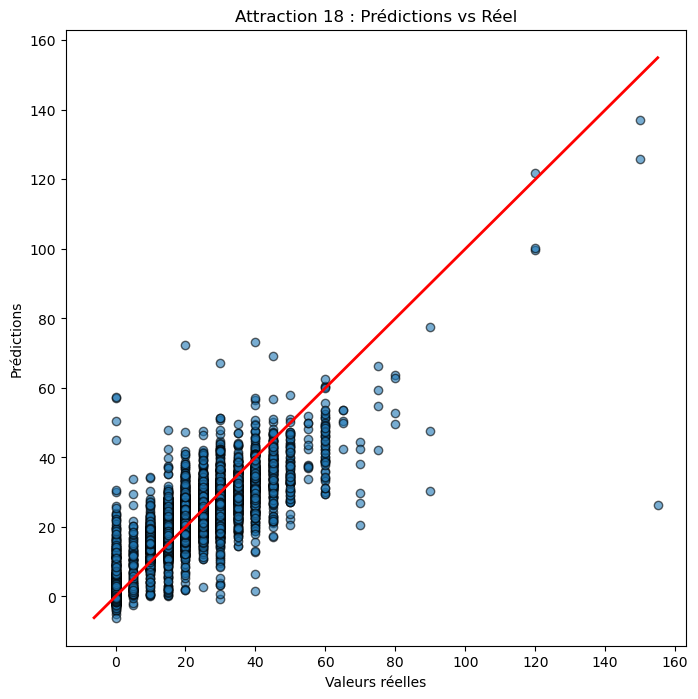

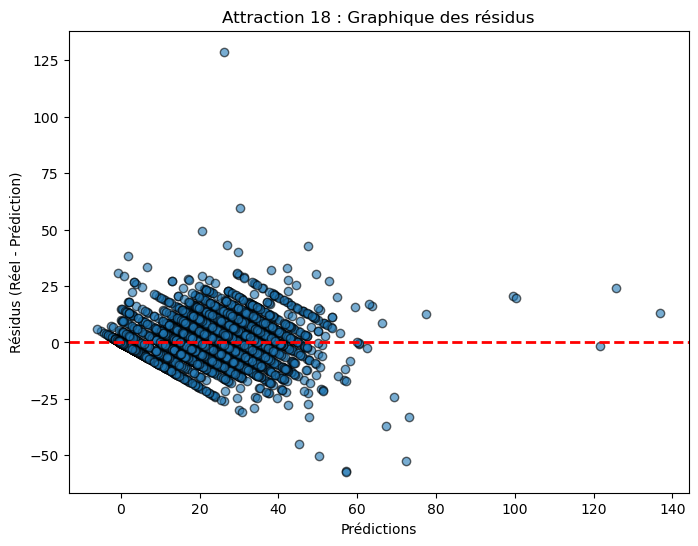

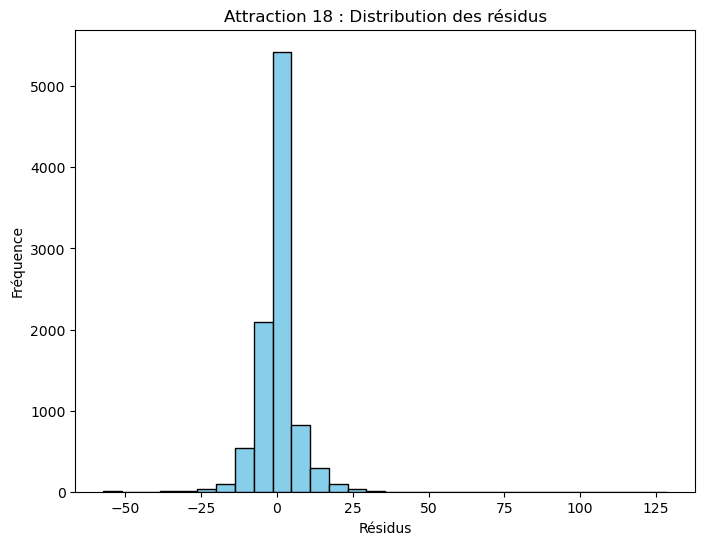

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 5.86771
[200]	valid_0's l1: 5.45877
[300]	valid_0's l1: 5.19771
[400]	valid_0's l1: 5.00205
[500]	valid_0's l1: 4.86501
[600]	valid_0's l1: 4.75241
[700]	valid_0's l1: 4.66193
[800]	valid_0's l1: 4.59829
[900]	valid_0's l1: 4.54317
[1000]	valid_0's l1: 4.49409
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 4.49409
Attraction 25 -> RMSE: 6.26, MAE: 4.49


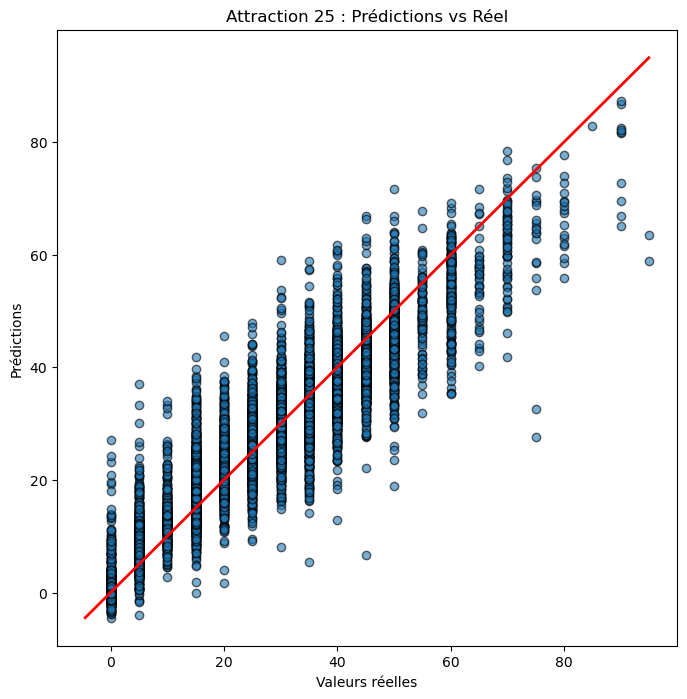

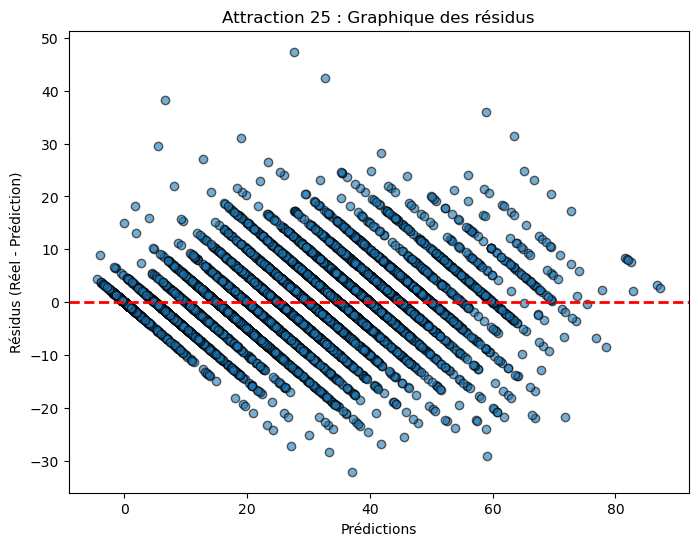

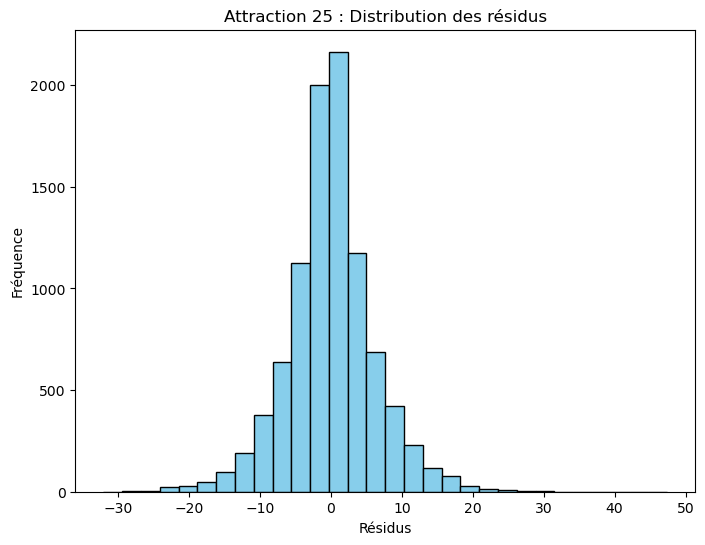

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 7.61766
[200]	valid_0's l1: 7.18192
[300]	valid_0's l1: 6.92649
[400]	valid_0's l1: 6.74912
[500]	valid_0's l1: 6.639
[600]	valid_0's l1: 6.54981
[700]	valid_0's l1: 6.48761
[800]	valid_0's l1: 6.42121
[900]	valid_0's l1: 6.37667
[1000]	valid_0's l1: 6.33345
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 6.33339
Attraction 19 -> RMSE: 9.94, MAE: 6.33


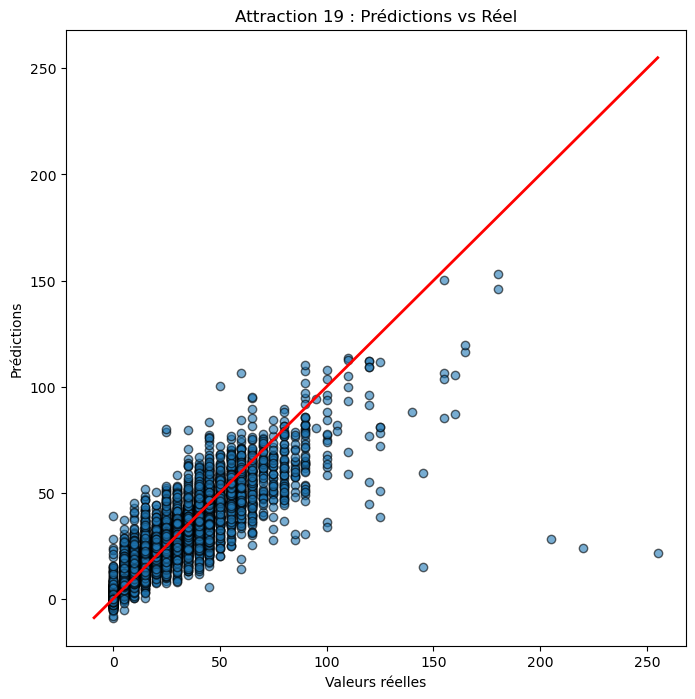

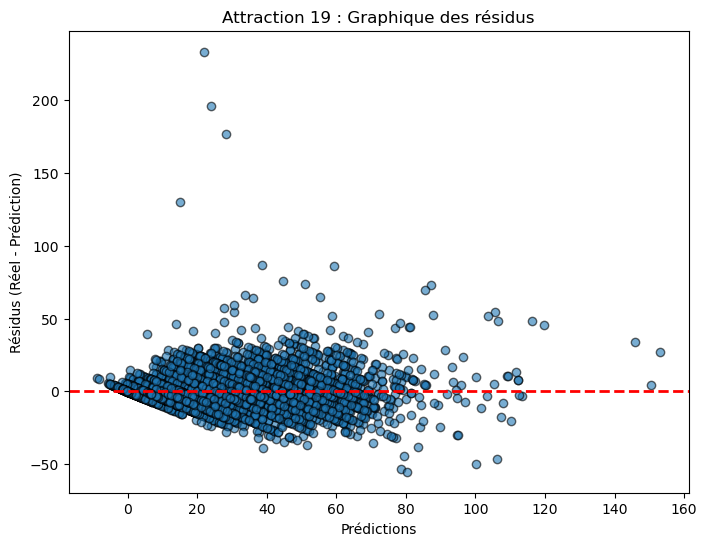

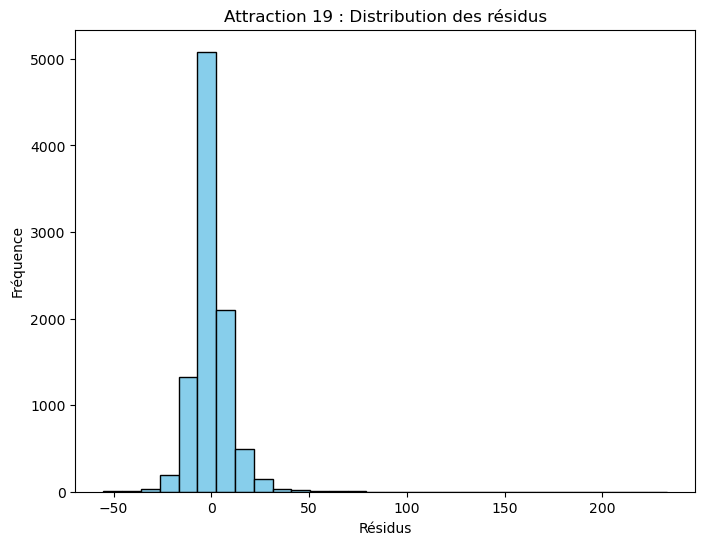

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 9.16697
[200]	valid_0's l1: 8.57152
[300]	valid_0's l1: 8.20413
[400]	valid_0's l1: 7.95744
[500]	valid_0's l1: 7.7738
[600]	valid_0's l1: 7.62678
[700]	valid_0's l1: 7.48888
[800]	valid_0's l1: 7.38687
[900]	valid_0's l1: 7.30982
[1000]	valid_0's l1: 7.24354
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 7.24354
Attraction 8 -> RMSE: 10.68, MAE: 7.24


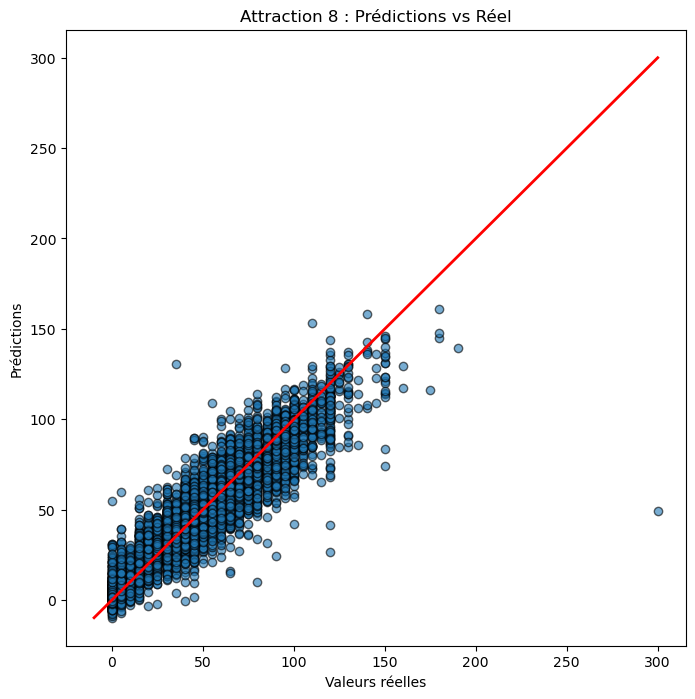

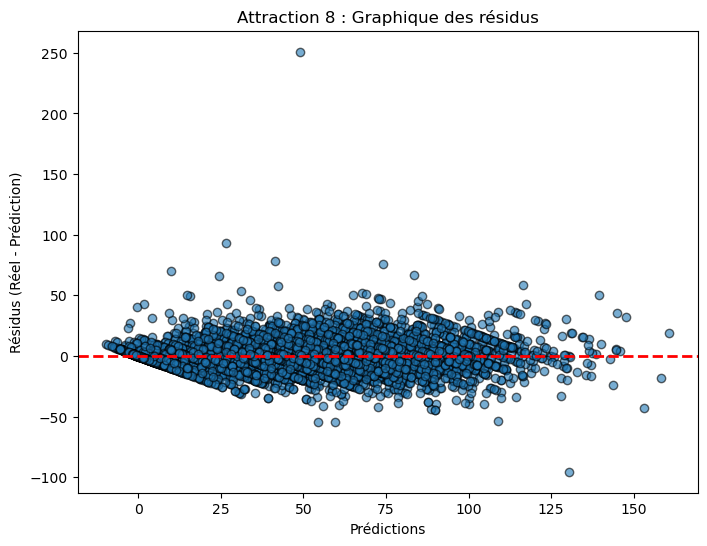

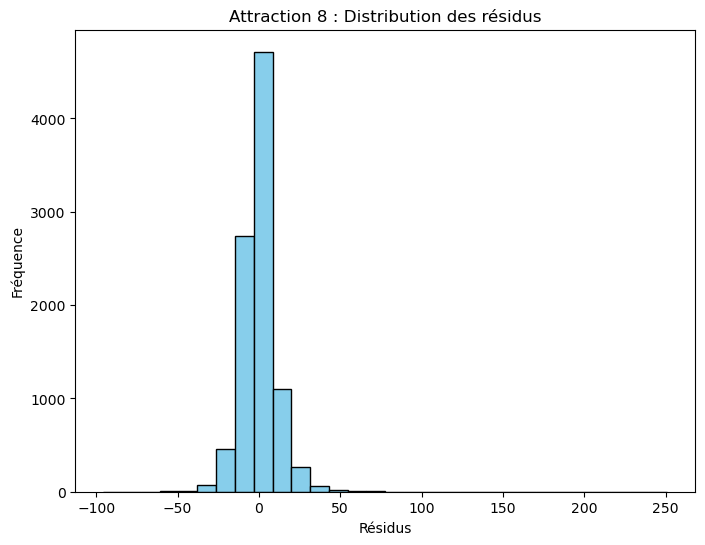

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 1.35381
[200]	valid_0's l1: 1.14977
[300]	valid_0's l1: 1.05253
[400]	valid_0's l1: 0.985527
[500]	valid_0's l1: 0.933526
[600]	valid_0's l1: 0.887812
[700]	valid_0's l1: 0.857595
[800]	valid_0's l1: 0.83217
[900]	valid_0's l1: 0.810394
[1000]	valid_0's l1: 0.793299
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.793299
Attraction 16 -> RMSE: 1.54, MAE: 0.79


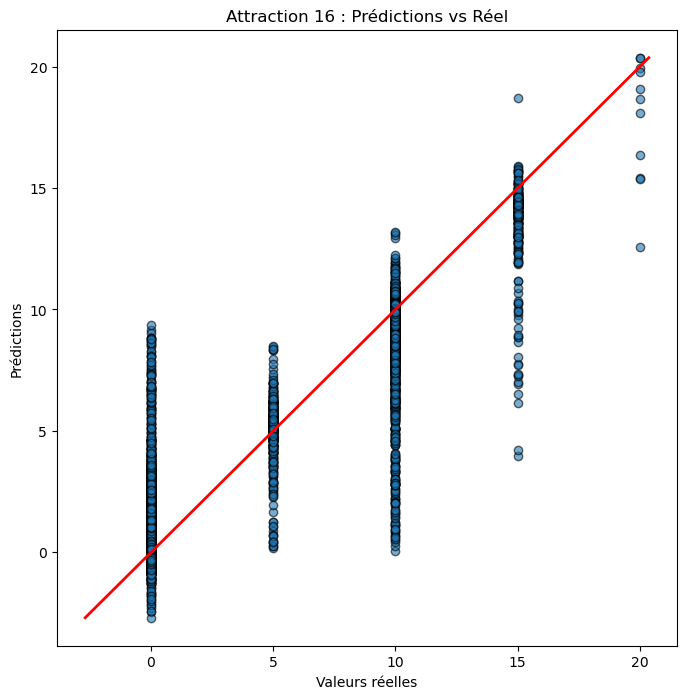

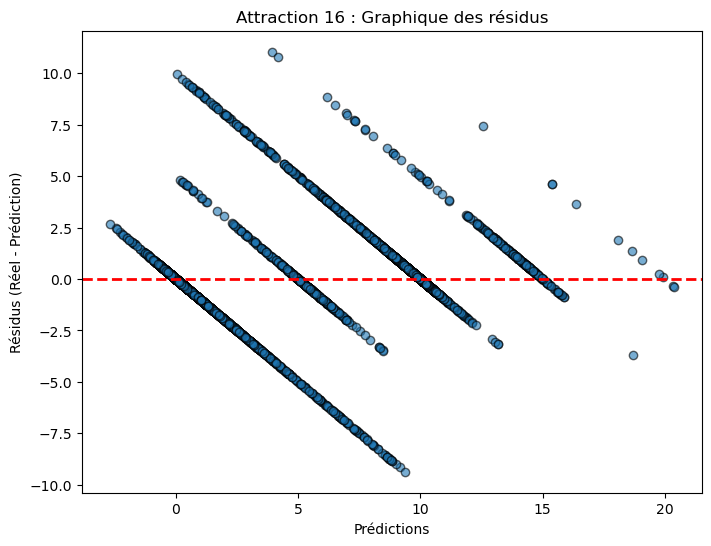

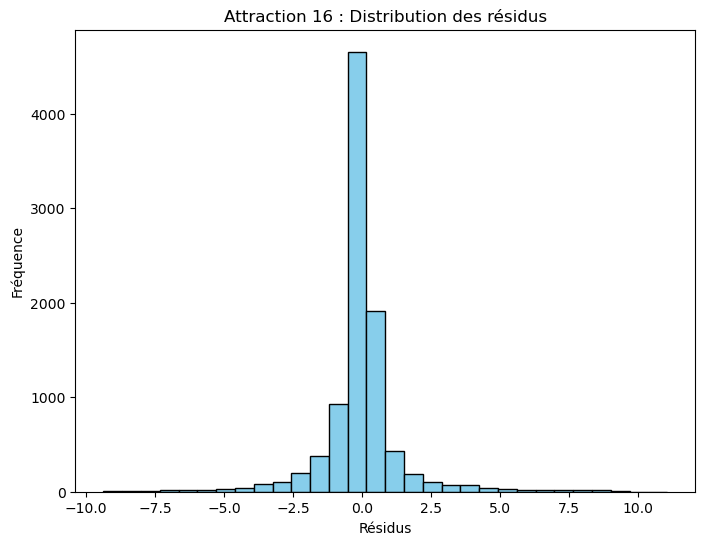

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 4.27642
[200]	valid_0's l1: 3.99622
[300]	valid_0's l1: 3.82687
[400]	valid_0's l1: 3.68946
[500]	valid_0's l1: 3.59999
[600]	valid_0's l1: 3.52079
[700]	valid_0's l1: 3.45592
[800]	valid_0's l1: 3.41056
[900]	valid_0's l1: 3.36939
[1000]	valid_0's l1: 3.32492
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.32492
Attraction 5 -> RMSE: 5.19, MAE: 3.32


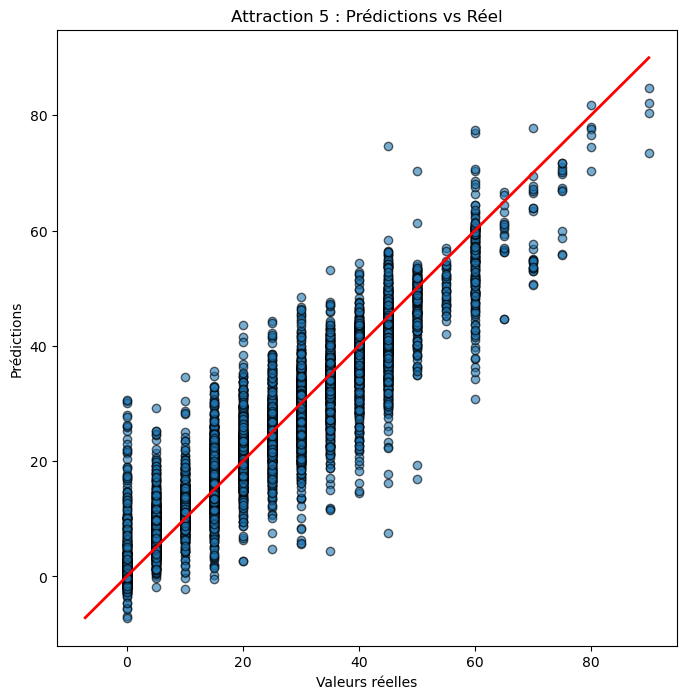

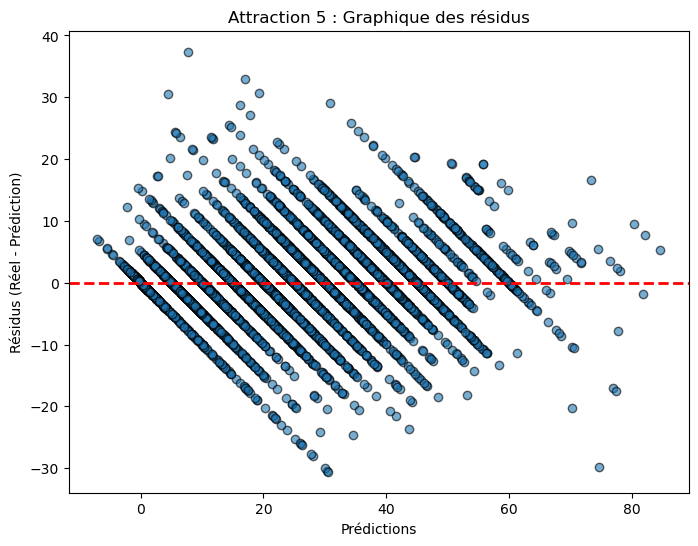

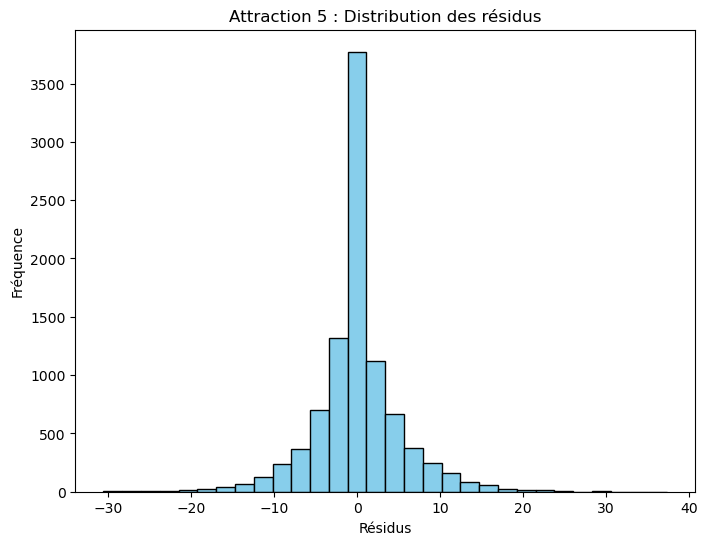

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 4.85196
[200]	valid_0's l1: 4.48411
[300]	valid_0's l1: 4.26283
[400]	valid_0's l1: 4.11635
[500]	valid_0's l1: 3.98912
[600]	valid_0's l1: 3.8917
[700]	valid_0's l1: 3.81896
[800]	valid_0's l1: 3.74577
[900]	valid_0's l1: 3.6963
[1000]	valid_0's l1: 3.65215
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.65215
Attraction 6 -> RMSE: 5.65, MAE: 3.65


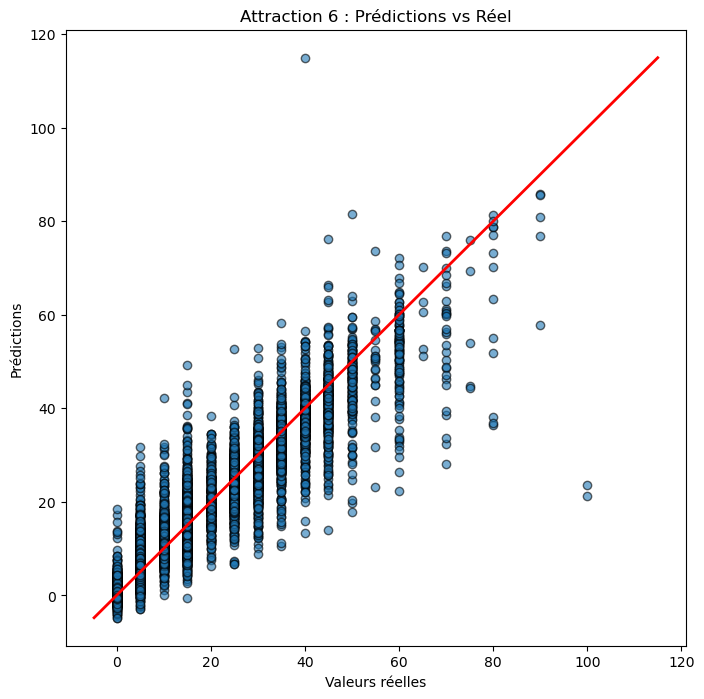

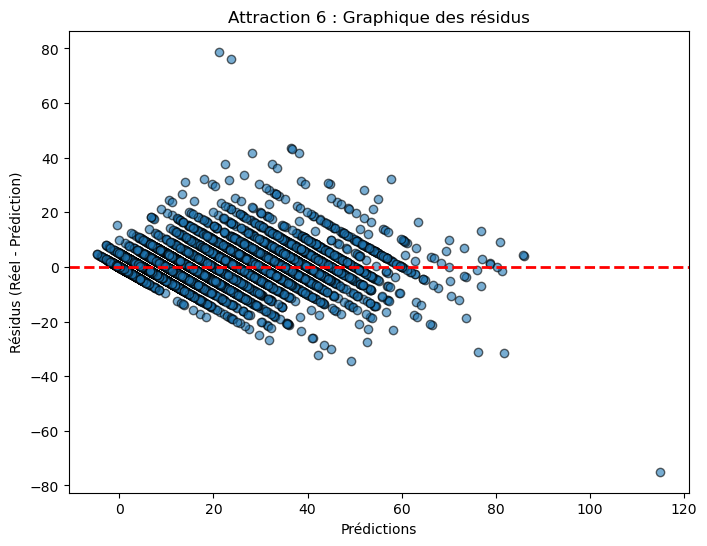

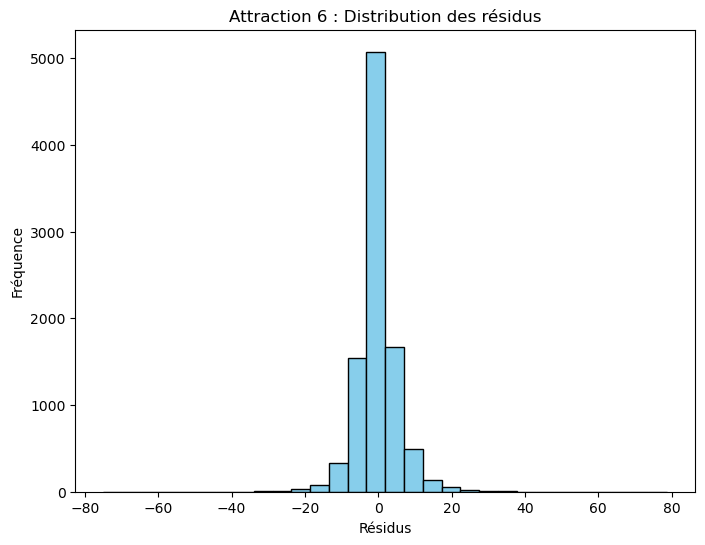

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 2.7117
[200]	valid_0's l1: 2.49152
[300]	valid_0's l1: 2.3778
[400]	valid_0's l1: 2.31158
[500]	valid_0's l1: 2.27063
[600]	valid_0's l1: 2.24346
[700]	valid_0's l1: 2.22055
[800]	valid_0's l1: 2.20512
[900]	valid_0's l1: 2.1973
[1000]	valid_0's l1: 2.1884
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 2.18783
Attraction 13 -> RMSE: 5.65, MAE: 2.19


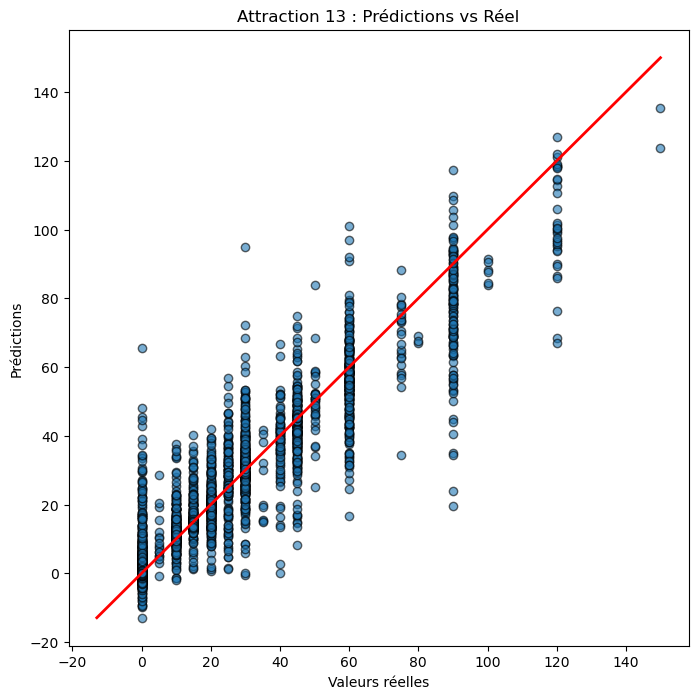

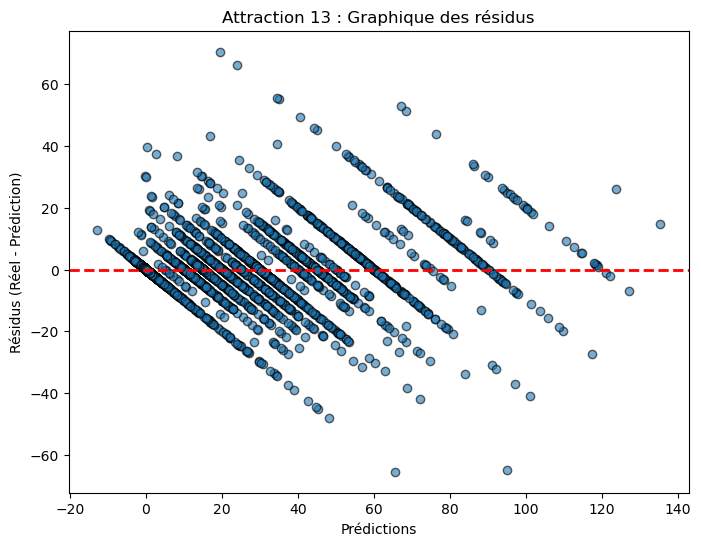

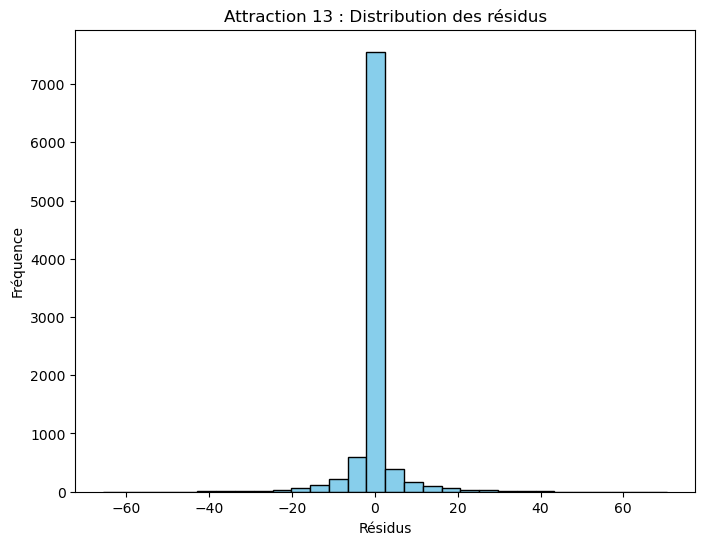

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 3.95259
[200]	valid_0's l1: 3.71355
[300]	valid_0's l1: 3.58935
[400]	valid_0's l1: 3.50347
[500]	valid_0's l1: 3.43076
[600]	valid_0's l1: 3.38172
[700]	valid_0's l1: 3.34368
[800]	valid_0's l1: 3.30601
[900]	valid_0's l1: 3.26878
[1000]	valid_0's l1: 3.24399
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.24399
Attraction 11 -> RMSE: 5.52, MAE: 3.24


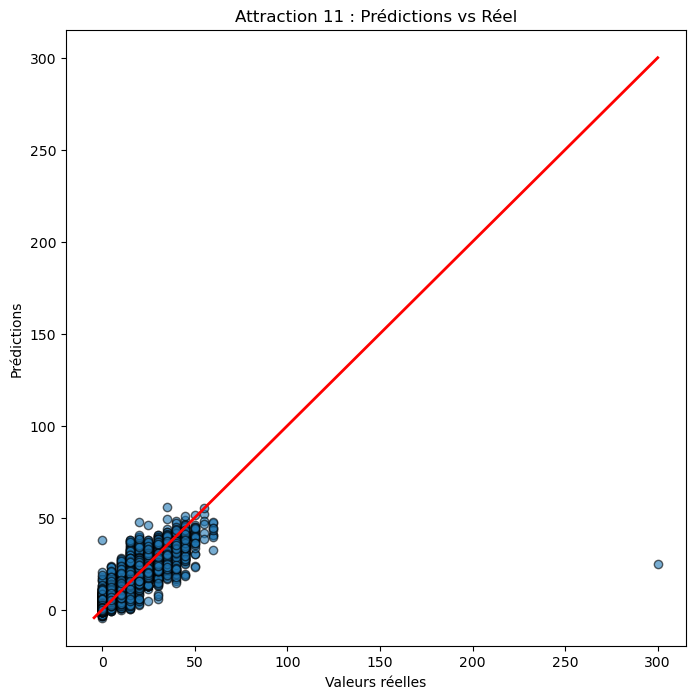

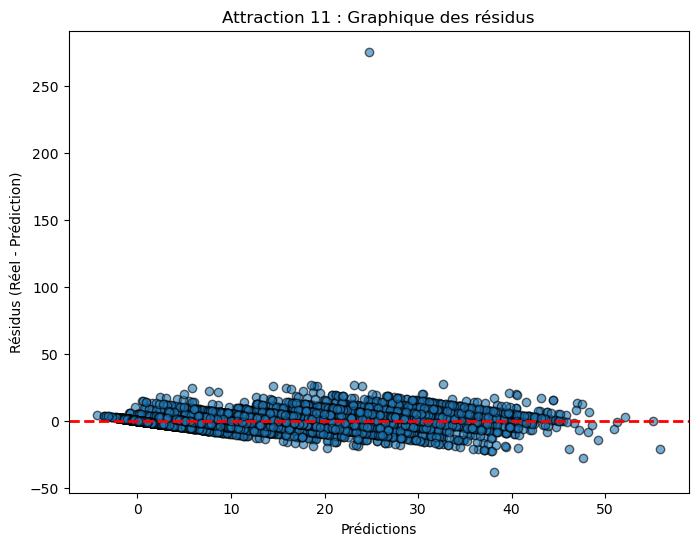

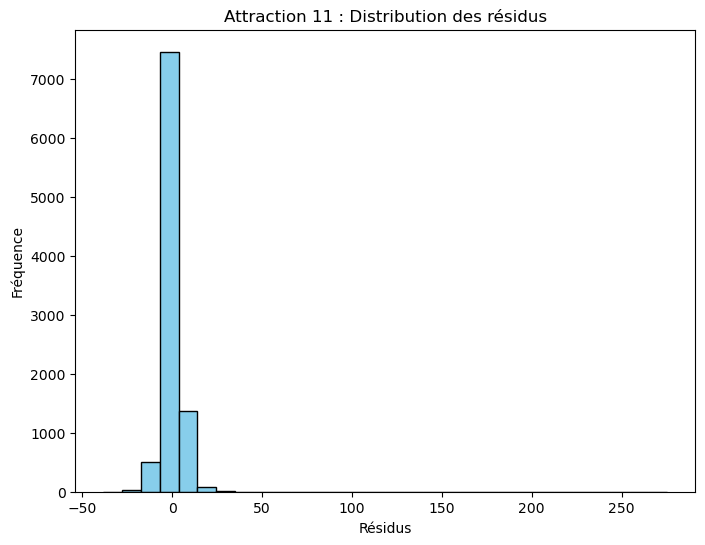

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 2.5472
[200]	valid_0's l1: 2.38863
[300]	valid_0's l1: 2.29762
[400]	valid_0's l1: 2.24438
[500]	valid_0's l1: 2.20256
[600]	valid_0's l1: 2.17481
[700]	valid_0's l1: 2.14961
[800]	valid_0's l1: 2.12978
[900]	valid_0's l1: 2.11189
[1000]	valid_0's l1: 2.09975
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 2.09974
Attraction 15 -> RMSE: 4.23, MAE: 2.10


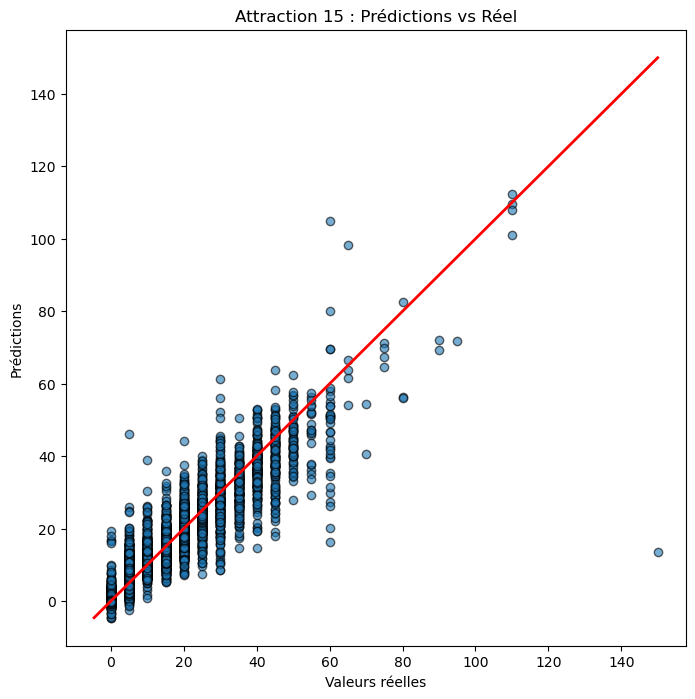

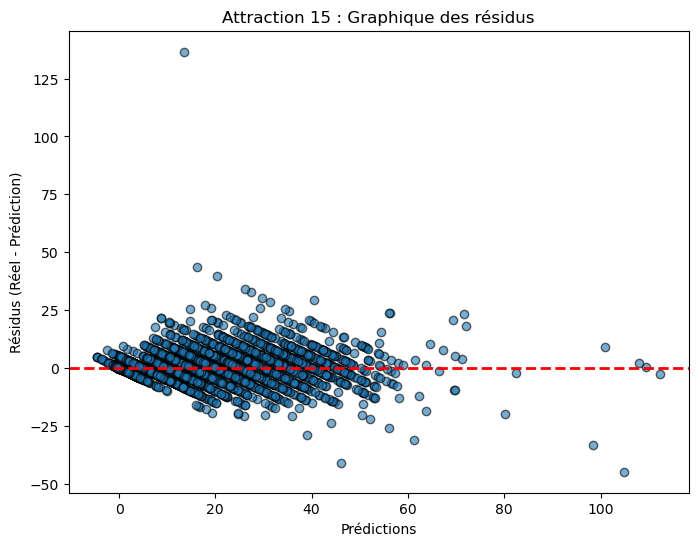

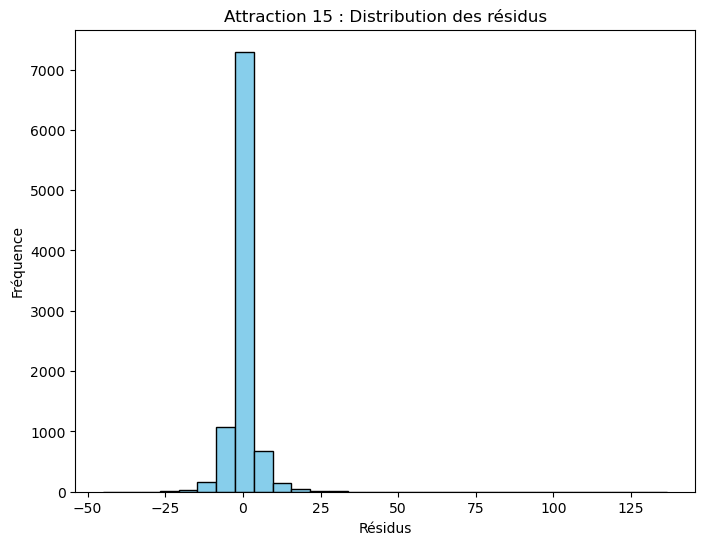

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 2.13023
[200]	valid_0's l1: 1.76803
[300]	valid_0's l1: 1.5795
[400]	valid_0's l1: 1.47
[500]	valid_0's l1: 1.39318
[600]	valid_0's l1: 1.3394
[700]	valid_0's l1: 1.29796
[800]	valid_0's l1: 1.26426
[900]	valid_0's l1: 1.24181
[1000]	valid_0's l1: 1.22044
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.22044
Attraction 21 -> RMSE: 2.82, MAE: 1.22


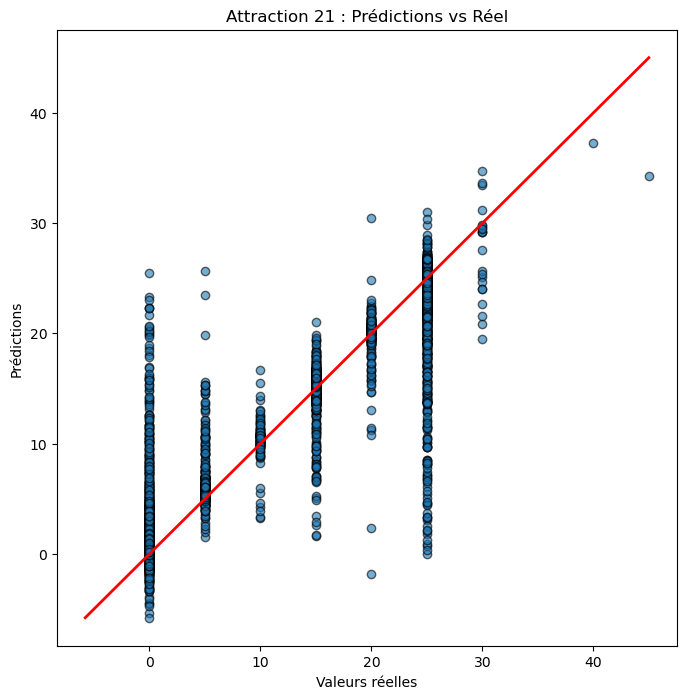

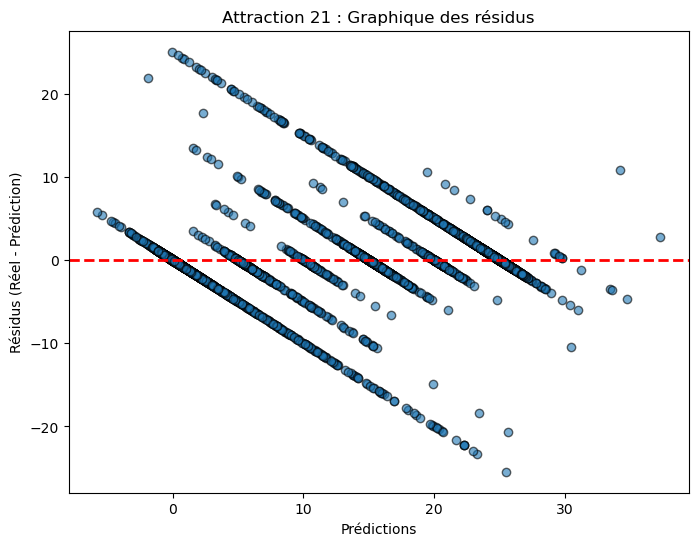

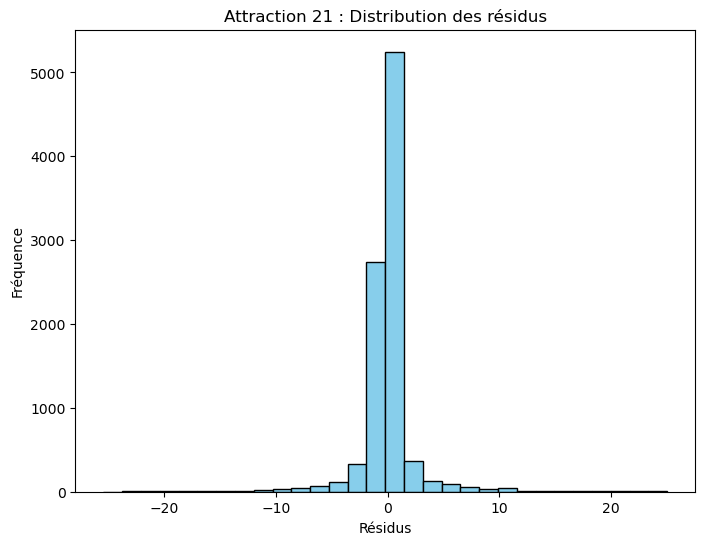

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.238372
[200]	valid_0's l1: 0.229161
[300]	valid_0's l1: 0.226758
Early stopping, best iteration is:
[261]	valid_0's l1: 0.225948
Attraction 3 -> RMSE: 0.80, MAE: 0.23


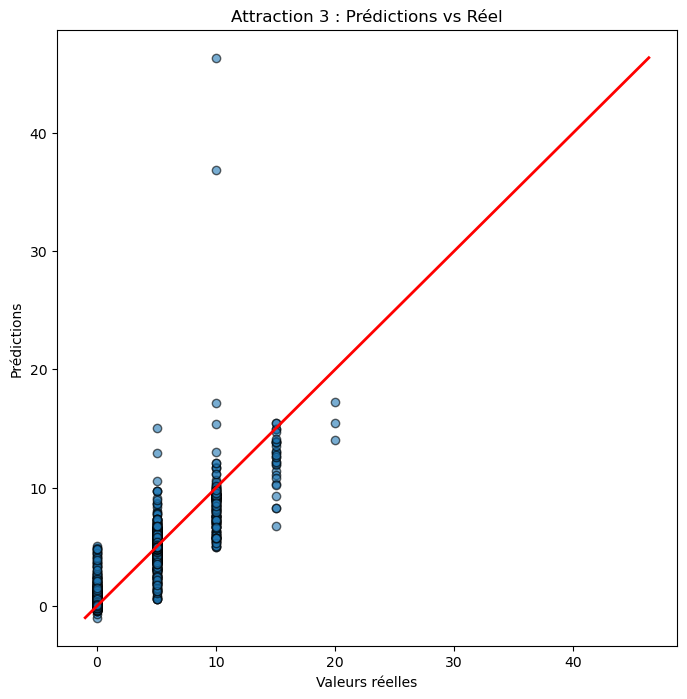

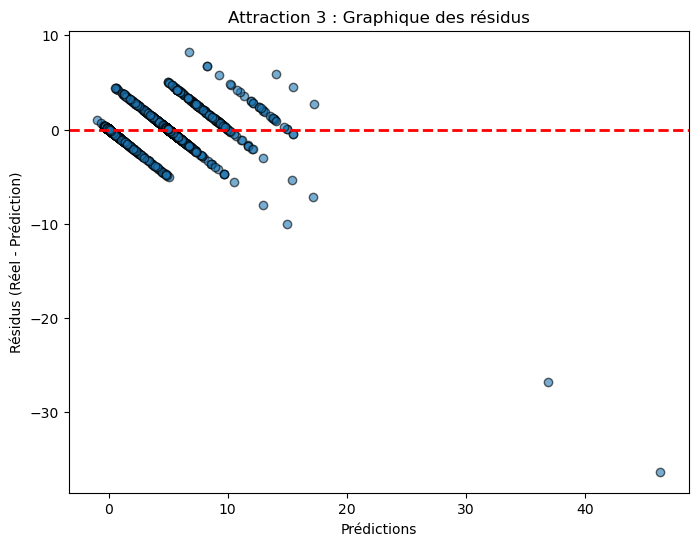

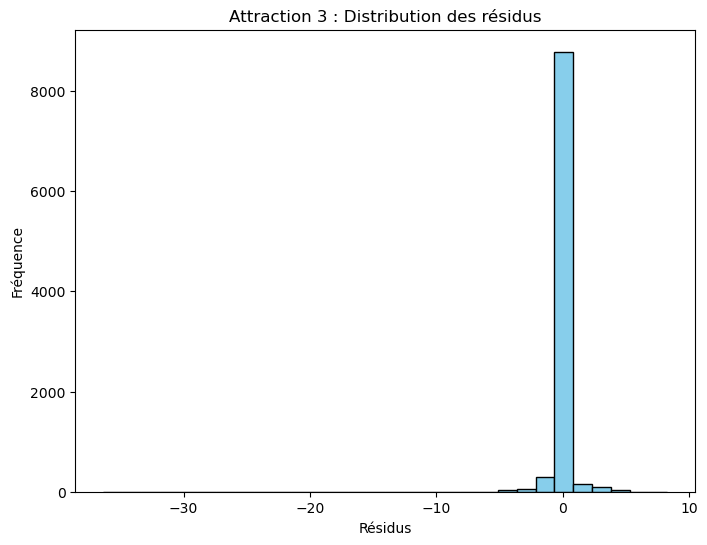

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 2.45765
[200]	valid_0's l1: 2.25243
[300]	valid_0's l1: 2.10997
[400]	valid_0's l1: 2.01439
[500]	valid_0's l1: 1.94149
[600]	valid_0's l1: 1.89053
[700]	valid_0's l1: 1.84529
[800]	valid_0's l1: 1.80657
[900]	valid_0's l1: 1.77829
[1000]	valid_0's l1: 1.75101
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.75101
Attraction 4 -> RMSE: 2.80, MAE: 1.75


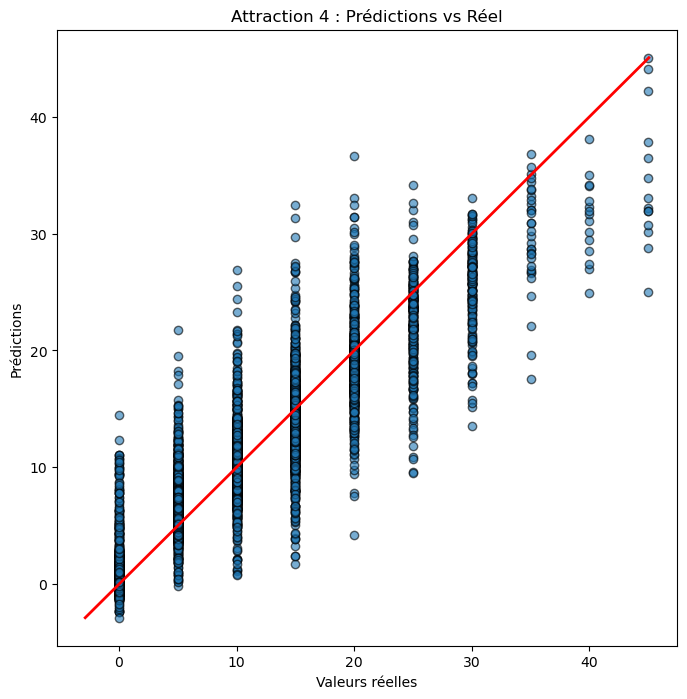

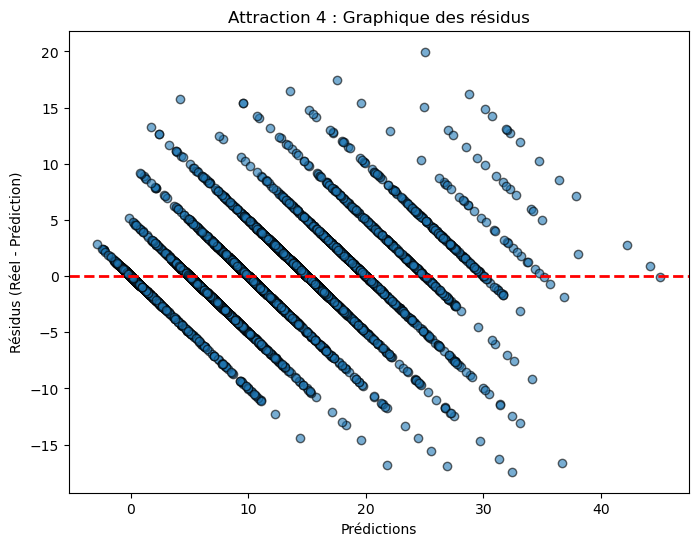

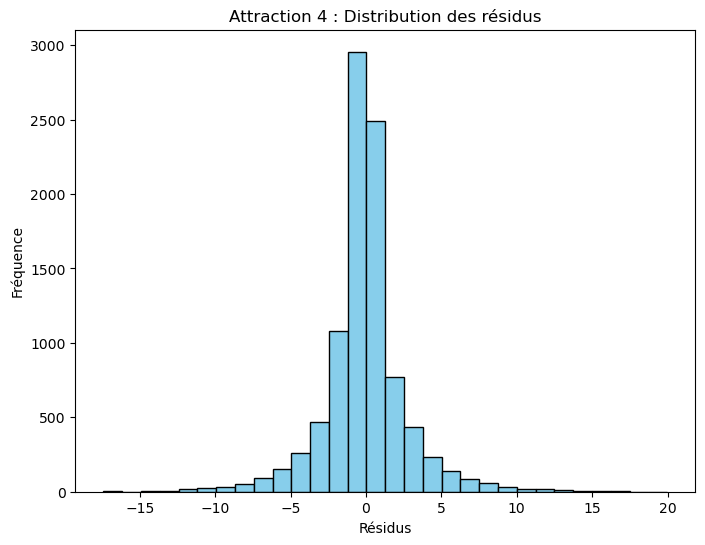

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 4.60129
[200]	valid_0's l1: 4.30673
[300]	valid_0's l1: 4.13372
[400]	valid_0's l1: 4.01248
[500]	valid_0's l1: 3.91289
[600]	valid_0's l1: 3.83586
[700]	valid_0's l1: 3.7805
[800]	valid_0's l1: 3.7389
[900]	valid_0's l1: 3.69751
[1000]	valid_0's l1: 3.66898
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.66898
Attraction 1 -> RMSE: 5.87, MAE: 3.67


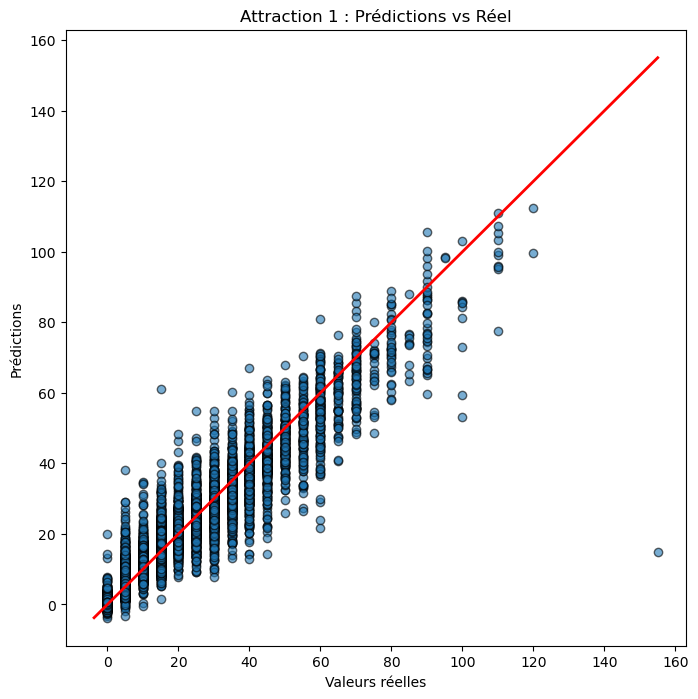

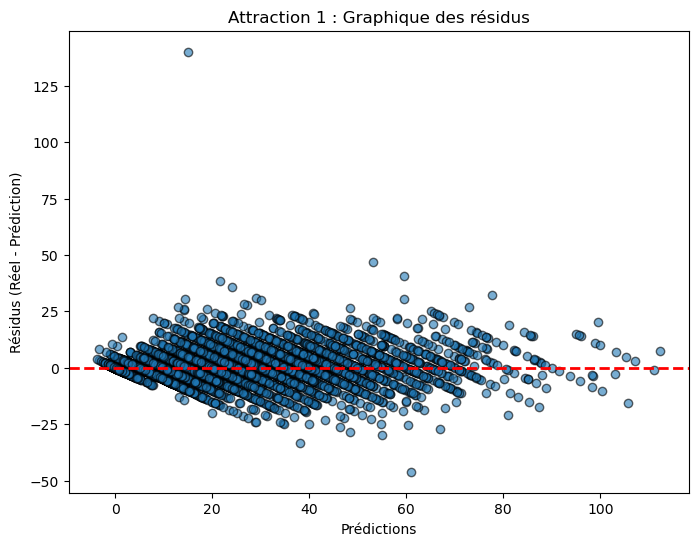

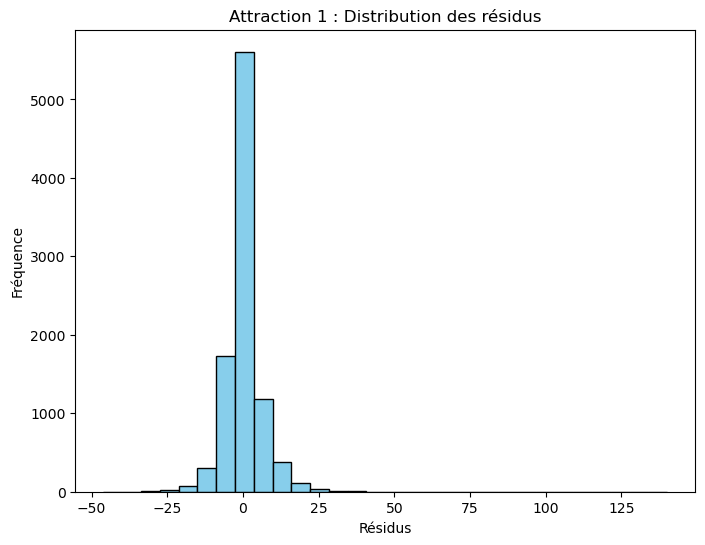

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 4.66127
[200]	valid_0's l1: 4.33013
[300]	valid_0's l1: 4.1158
[400]	valid_0's l1: 3.95888
[500]	valid_0's l1: 3.85939
[600]	valid_0's l1: 3.78062
[700]	valid_0's l1: 3.71392
[800]	valid_0's l1: 3.66006
[900]	valid_0's l1: 3.60917
[1000]	valid_0's l1: 3.57847
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.57847
Attraction 17 -> RMSE: 6.49, MAE: 3.58


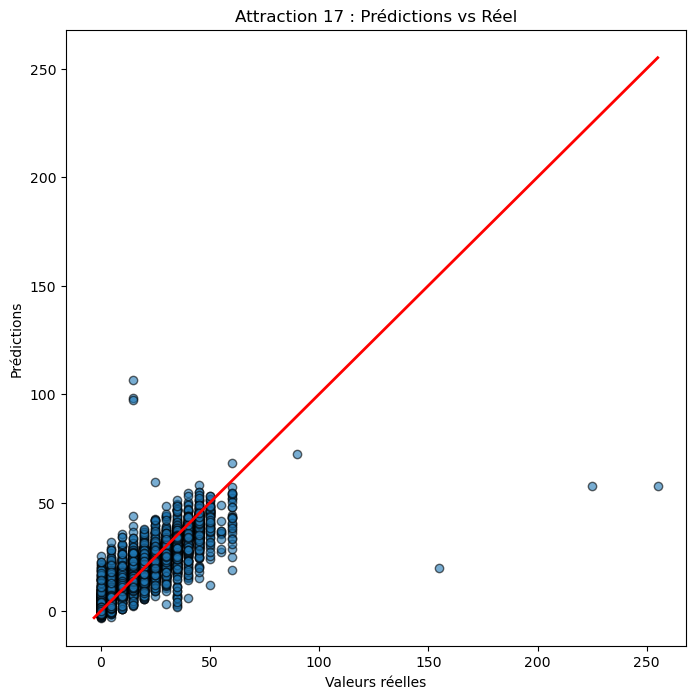

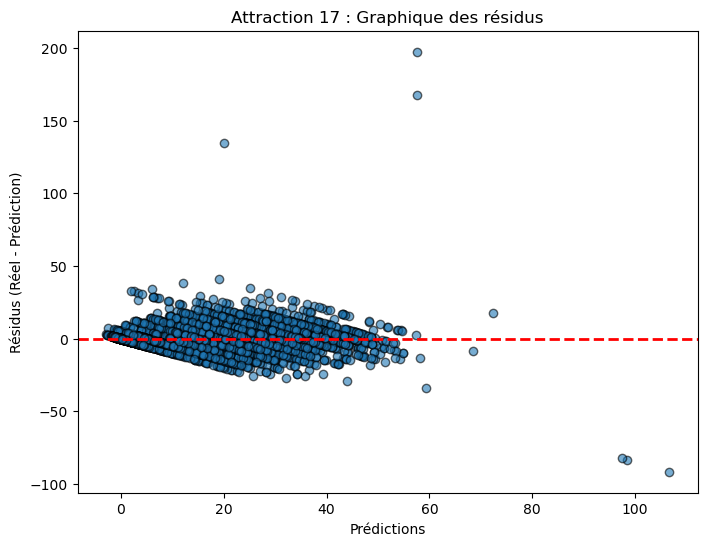

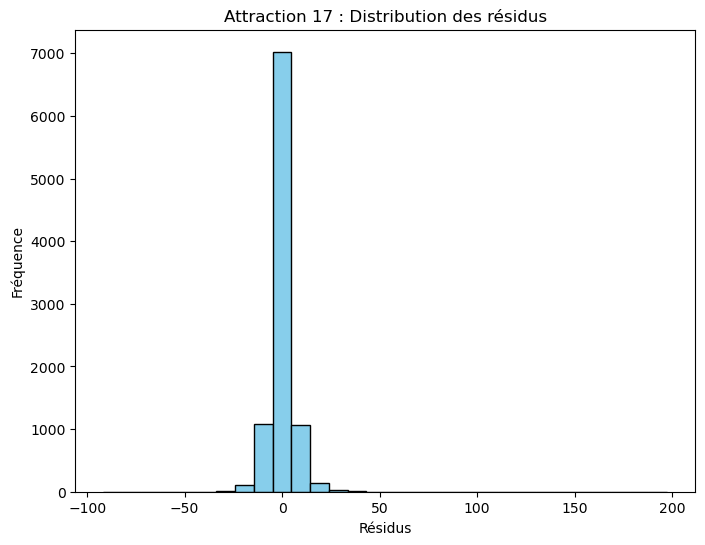

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 2.52494
[200]	valid_0's l1: 2.36742
[300]	valid_0's l1: 2.26312
[400]	valid_0's l1: 2.20616
[500]	valid_0's l1: 2.15015
[600]	valid_0's l1: 2.1155
[700]	valid_0's l1: 2.09373
[800]	valid_0's l1: 2.06617
[900]	valid_0's l1: 2.04773
[1000]	valid_0's l1: 2.03071
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 2.03067
Attraction 9 -> RMSE: 3.98, MAE: 2.03


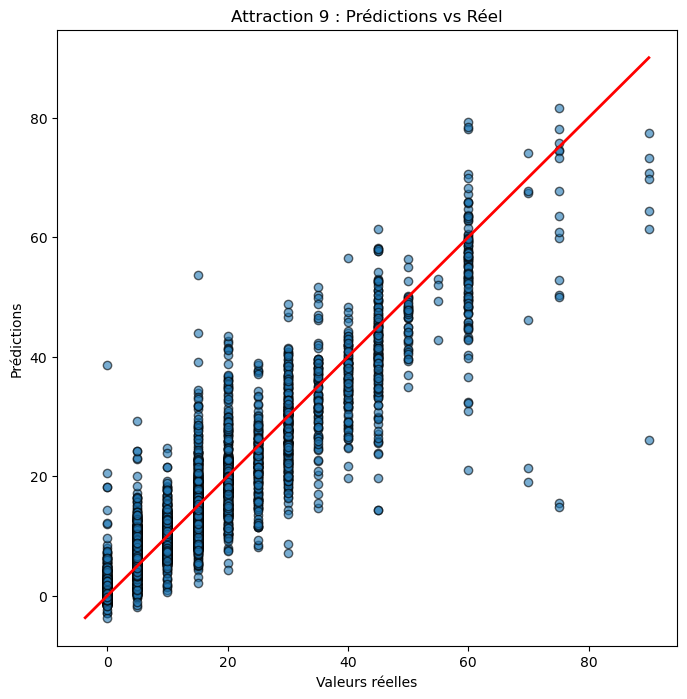

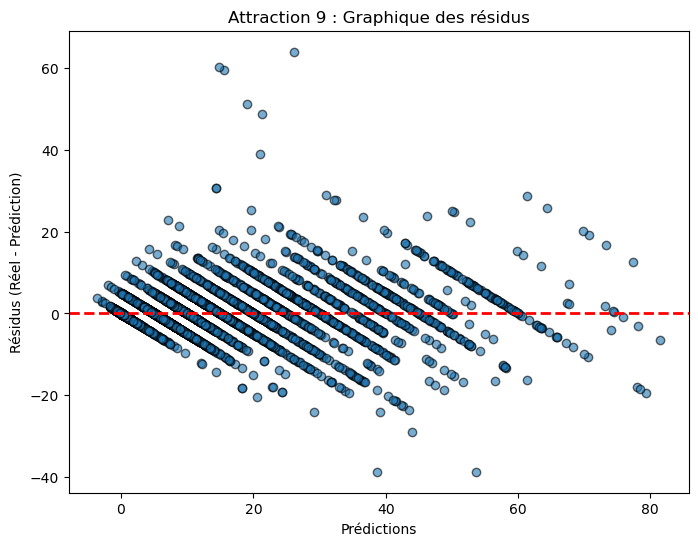

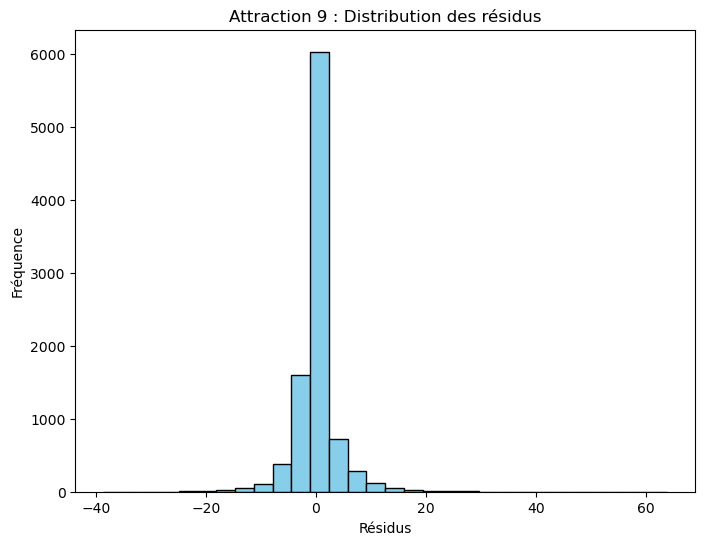

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 6.95159
[200]	valid_0's l1: 6.45291
[300]	valid_0's l1: 6.15004
[400]	valid_0's l1: 5.93721
[500]	valid_0's l1: 5.80564
[600]	valid_0's l1: 5.7145
[700]	valid_0's l1: 5.61957
[800]	valid_0's l1: 5.54121
[900]	valid_0's l1: 5.48201
[1000]	valid_0's l1: 5.43663
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 5.43563
Attraction 10 -> RMSE: 8.64, MAE: 5.44


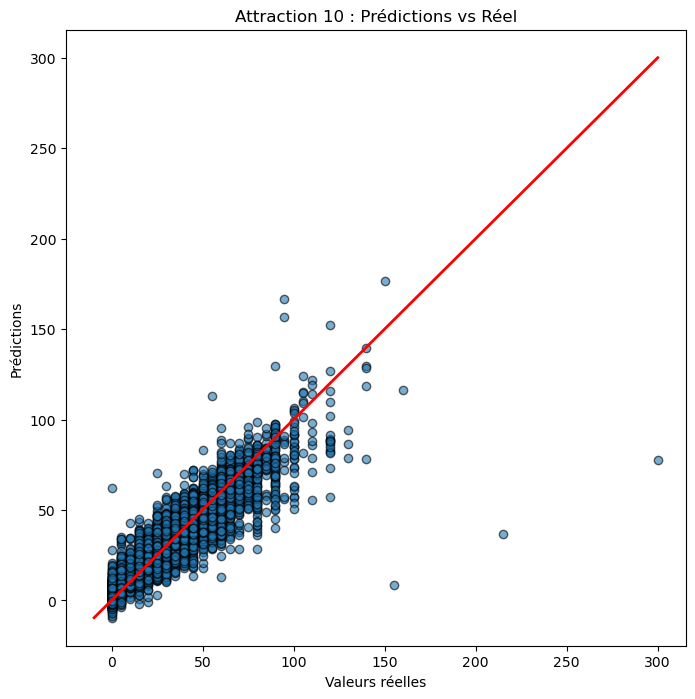

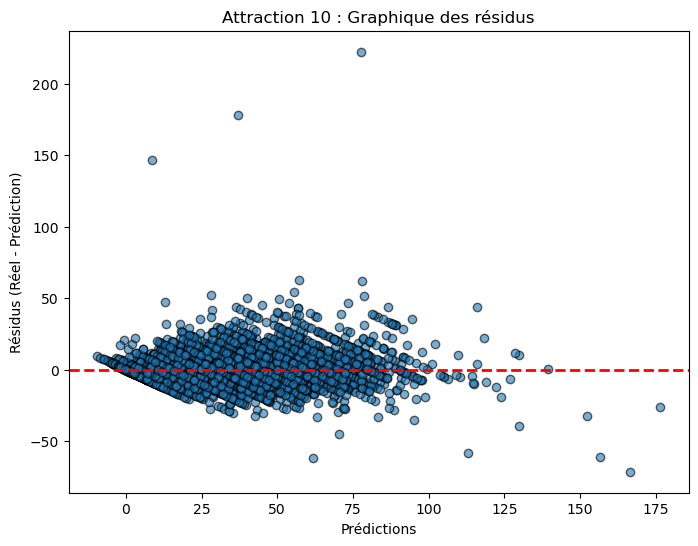

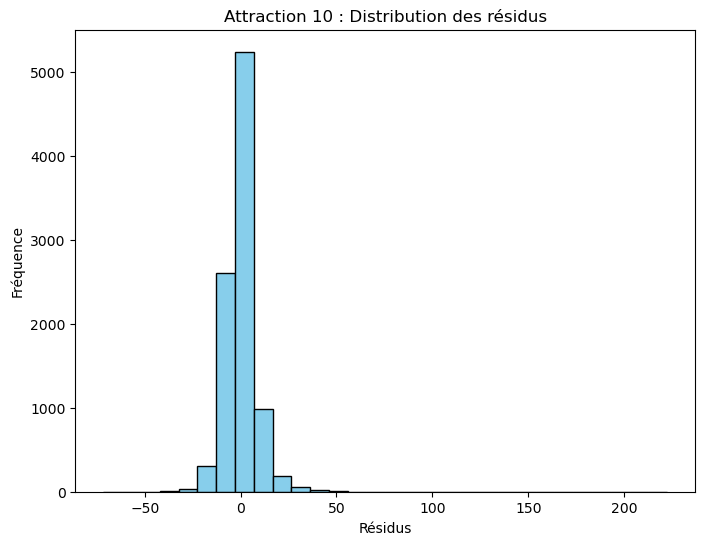

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 2.36783
[200]	valid_0's l1: 2.23064
[300]	valid_0's l1: 2.14571
[400]	valid_0's l1: 2.08748
[500]	valid_0's l1: 2.03411
[600]	valid_0's l1: 2.00302
[700]	valid_0's l1: 1.97354
[800]	valid_0's l1: 1.95316
[900]	valid_0's l1: 1.9335
[1000]	valid_0's l1: 1.90894
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.90894
Attraction 0 -> RMSE: 3.05, MAE: 1.91


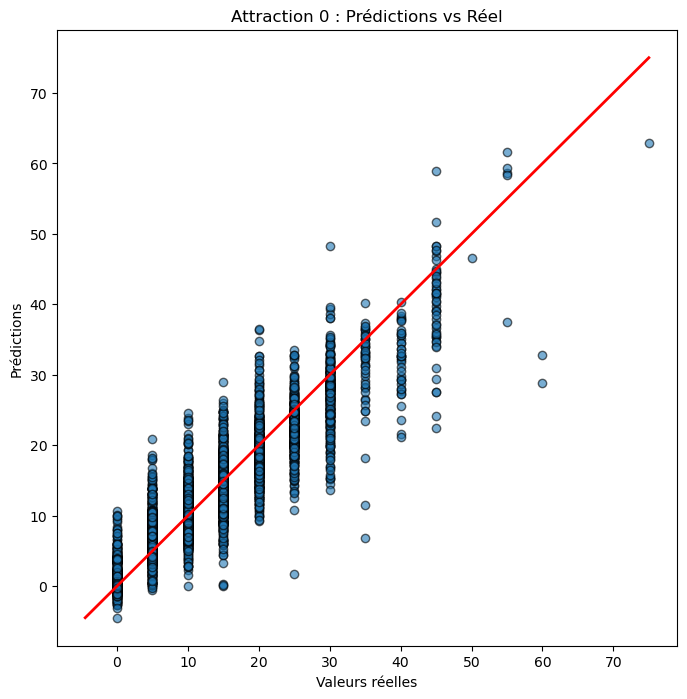

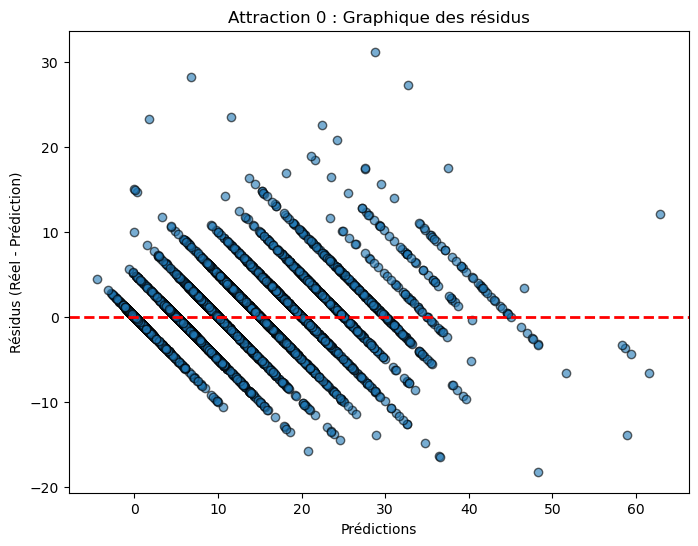

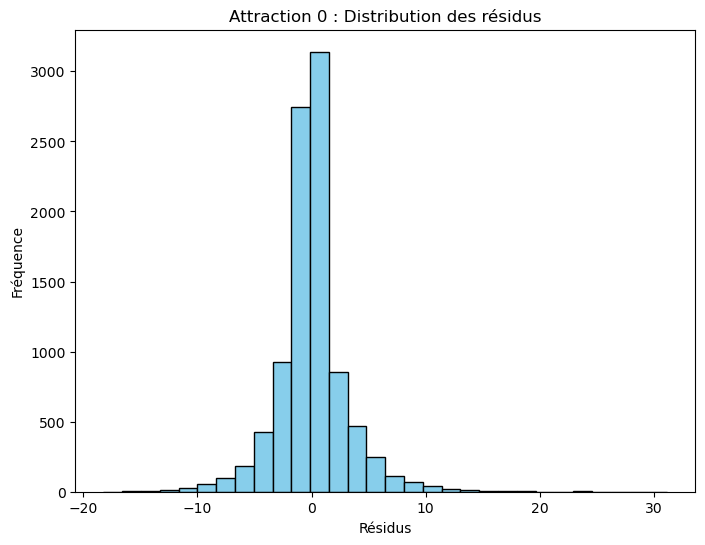

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 7.13106
[200]	valid_0's l1: 6.78277
[300]	valid_0's l1: 6.54616
[400]	valid_0's l1: 6.39618
[500]	valid_0's l1: 6.29797
[600]	valid_0's l1: 6.20595
[700]	valid_0's l1: 6.13773
[800]	valid_0's l1: 6.09726
[900]	valid_0's l1: 6.06454
[1000]	valid_0's l1: 6.03127
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 6.03127
Attraction 22 -> RMSE: 9.48, MAE: 6.03


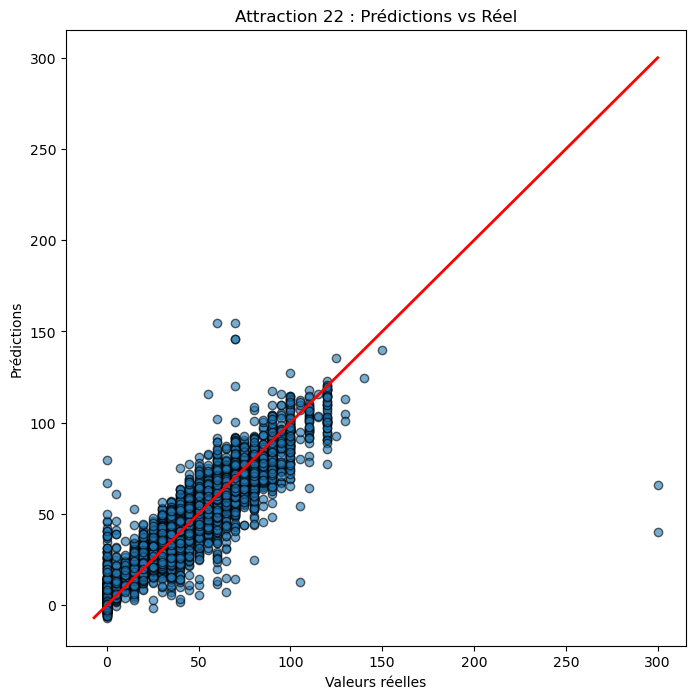

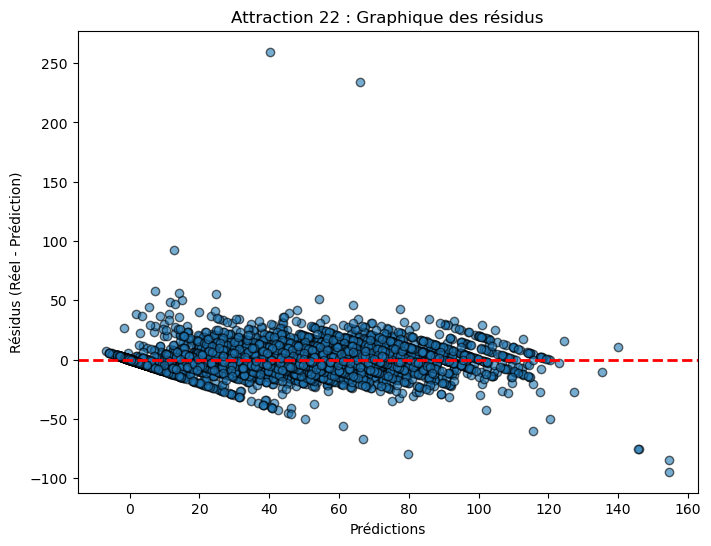

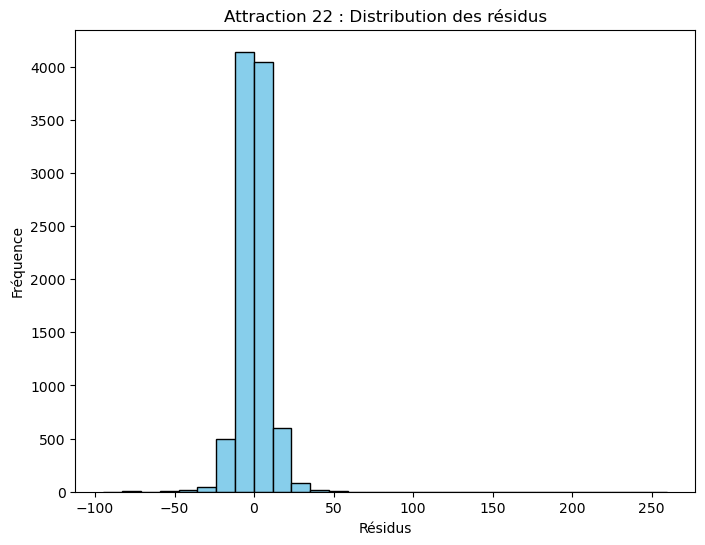

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 7
[200]	valid_0's l1: 6.65293
[300]	valid_0's l1: 6.44223
[400]	valid_0's l1: 6.31053
[500]	valid_0's l1: 6.21633
[600]	valid_0's l1: 6.1425
[700]	valid_0's l1: 6.06476
[800]	valid_0's l1: 6.03264
[900]	valid_0's l1: 6.01313
[1000]	valid_0's l1: 5.9893
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 5.9893
Attraction 7 -> RMSE: 10.58, MAE: 5.99


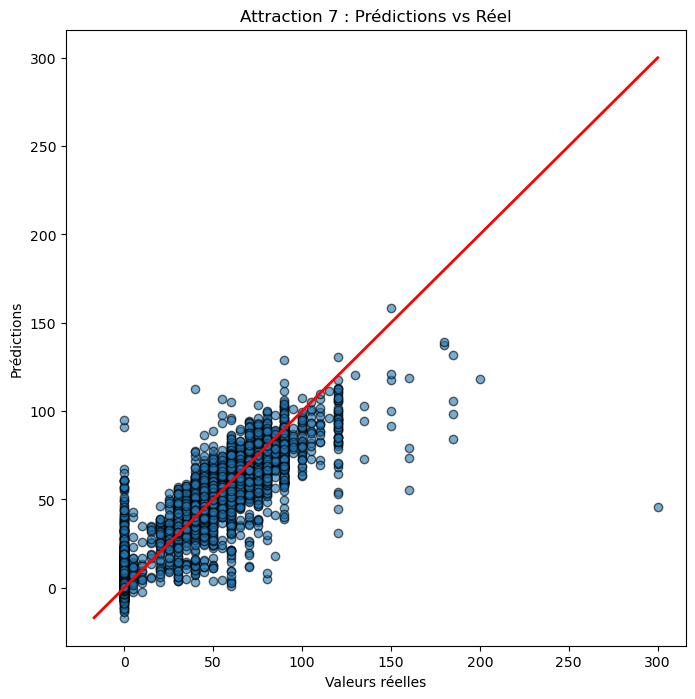

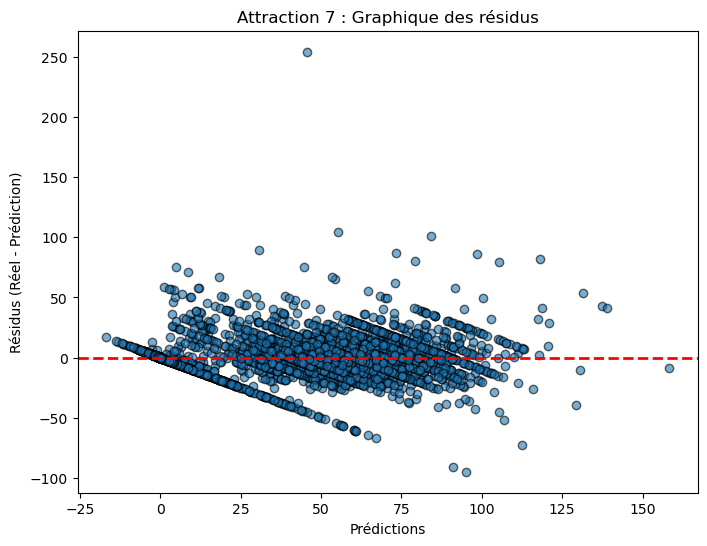

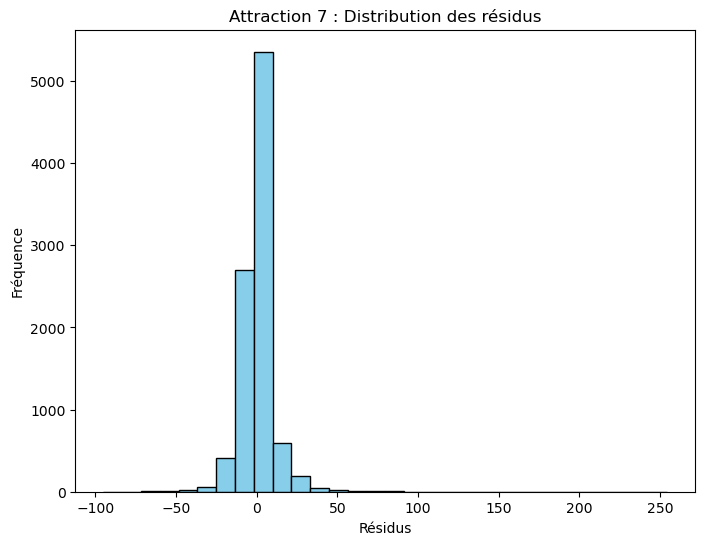

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 1.69024
[200]	valid_0's l1: 1.53681
[300]	valid_0's l1: 1.45048
[400]	valid_0's l1: 1.39335
[500]	valid_0's l1: 1.35706
[600]	valid_0's l1: 1.33121
[700]	valid_0's l1: 1.31105
[800]	valid_0's l1: 1.28906
[900]	valid_0's l1: 1.27213
[1000]	valid_0's l1: 1.25544
Did not meet early stopping. Best iteration is:
[992]	valid_0's l1: 1.25538
Attraction 14 -> RMSE: 2.43, MAE: 1.26


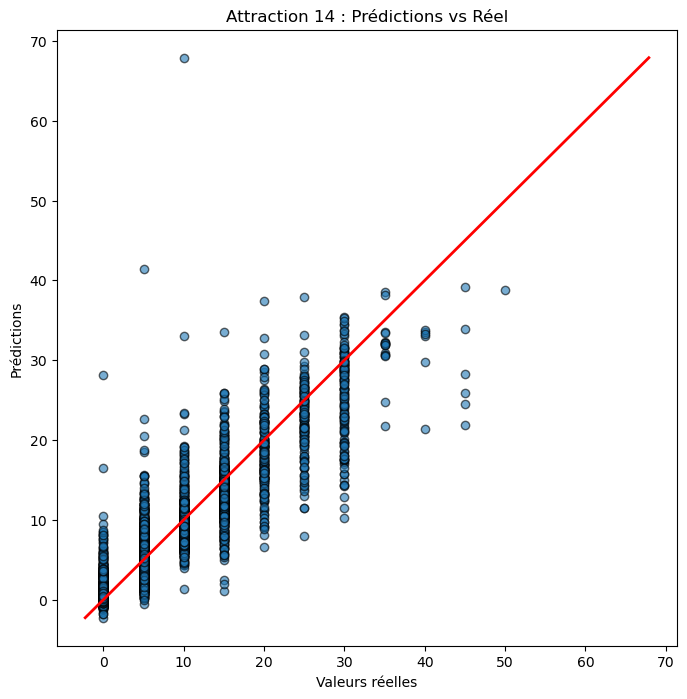

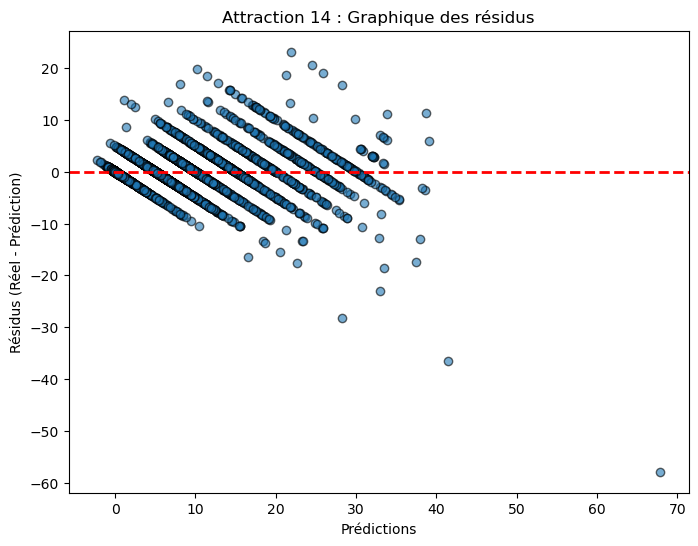

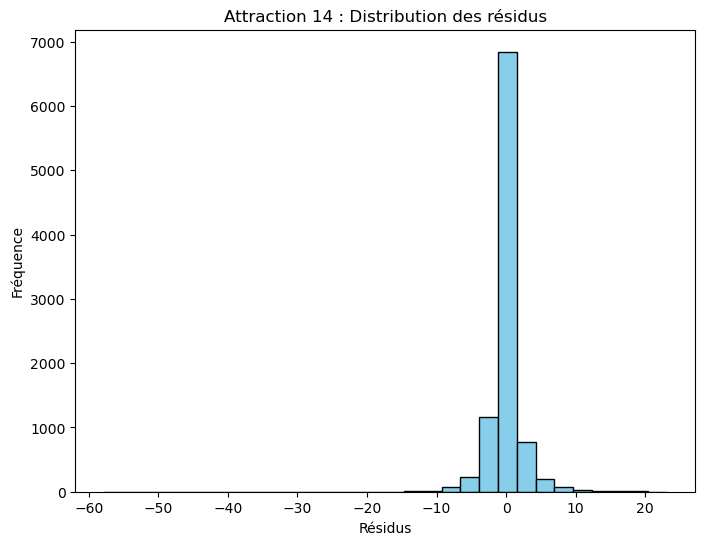

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 12.974
[200]	valid_0's l1: 11.9258
[300]	valid_0's l1: 11.1933
[400]	valid_0's l1: 10.7553
[500]	valid_0's l1: 10.4303
[600]	valid_0's l1: 10.1342
[700]	valid_0's l1: 9.9154
[800]	valid_0's l1: 9.69963
[900]	valid_0's l1: 9.52061
[1000]	valid_0's l1: 9.39578
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 9.39578
Attraction 20 -> RMSE: 15.21, MAE: 9.40


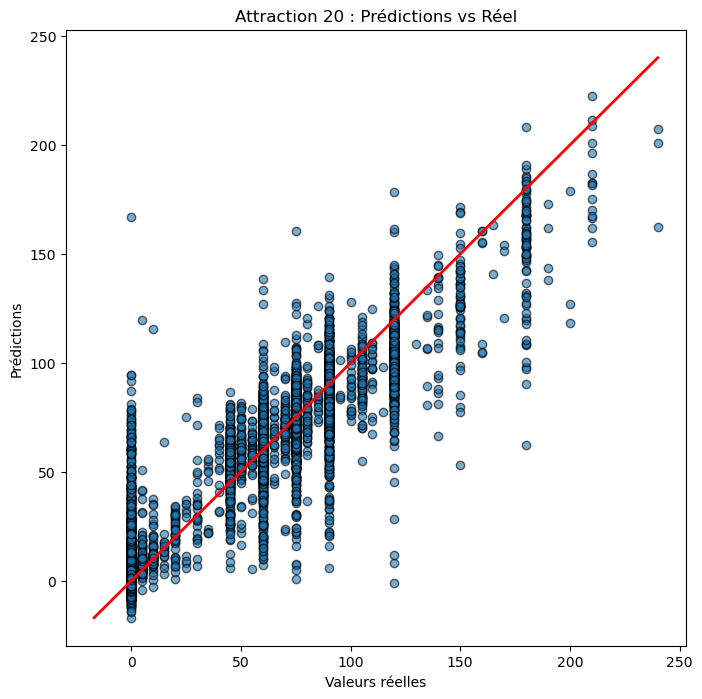

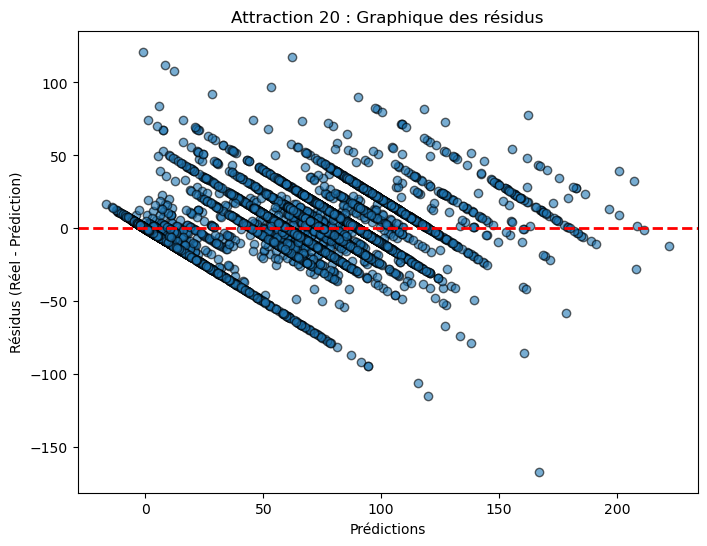

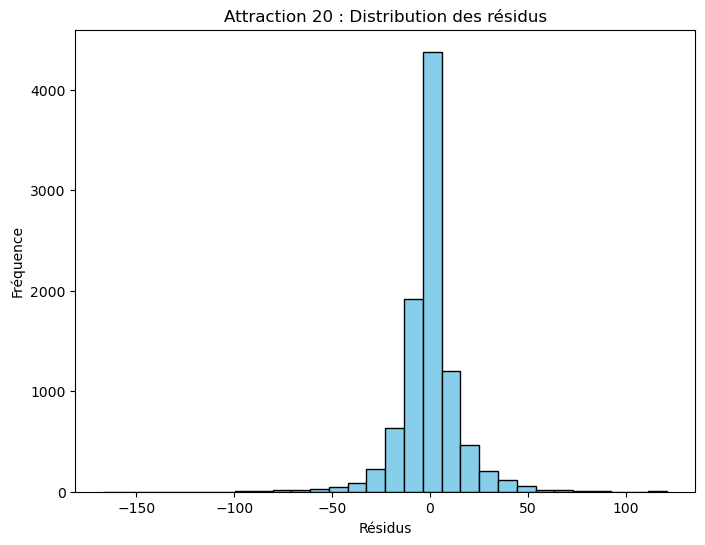

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.501474
[200]	valid_0's l1: 0.462583
[300]	valid_0's l1: 0.444695
[400]	valid_0's l1: 0.434133
[500]	valid_0's l1: 0.423135
[600]	valid_0's l1: 0.417843
[700]	valid_0's l1: 0.41309
[800]	valid_0's l1: 0.409593
[900]	valid_0's l1: 0.408125
[1000]	valid_0's l1: 0.406259
Did not meet early stopping. Best iteration is:
[991]	valid_0's l1: 0.406208
Attraction 2 -> RMSE: 1.00, MAE: 0.41


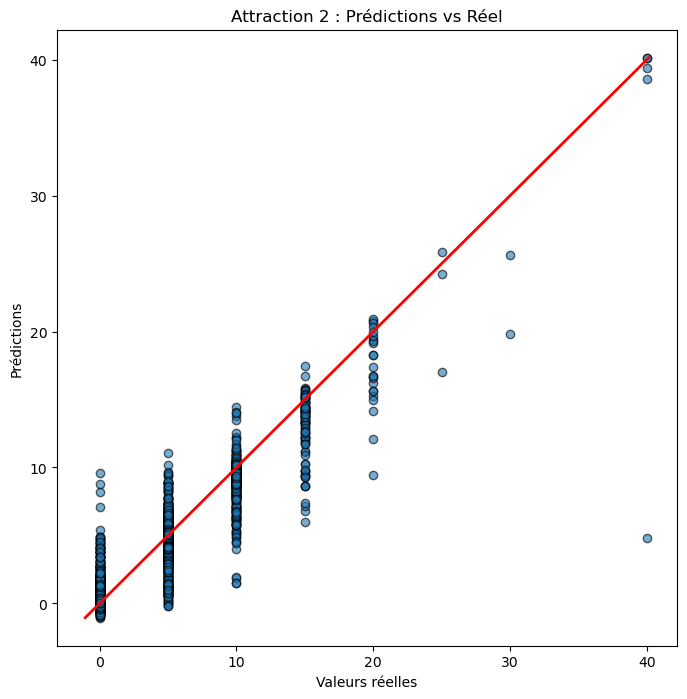

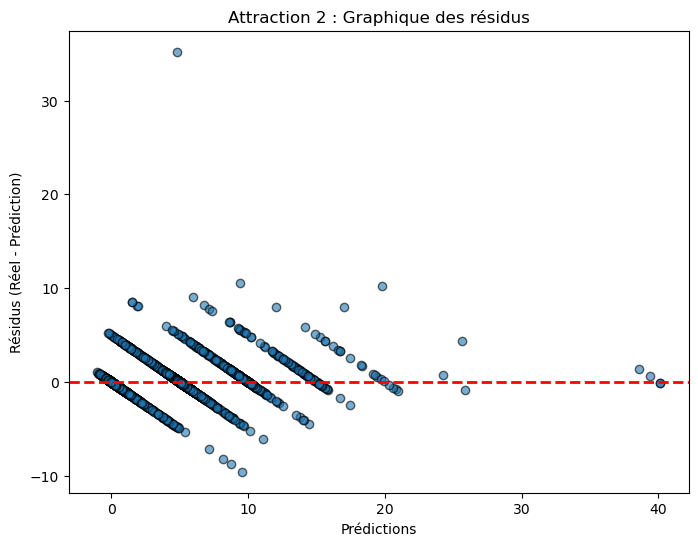

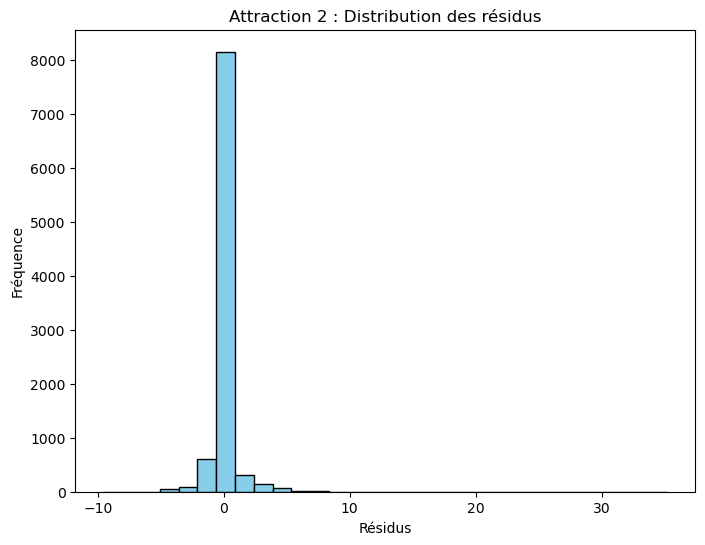

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 4.29299
[200]	valid_0's l1: 4.02956
[300]	valid_0's l1: 3.87042
[400]	valid_0's l1: 3.74339
[500]	valid_0's l1: 3.66042
[600]	valid_0's l1: 3.58061
[700]	valid_0's l1: 3.52936
[800]	valid_0's l1: 3.4829
[900]	valid_0's l1: 3.44472
[1000]	valid_0's l1: 3.41425
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 3.41425
Attraction 24 -> RMSE: 5.03, MAE: 3.41


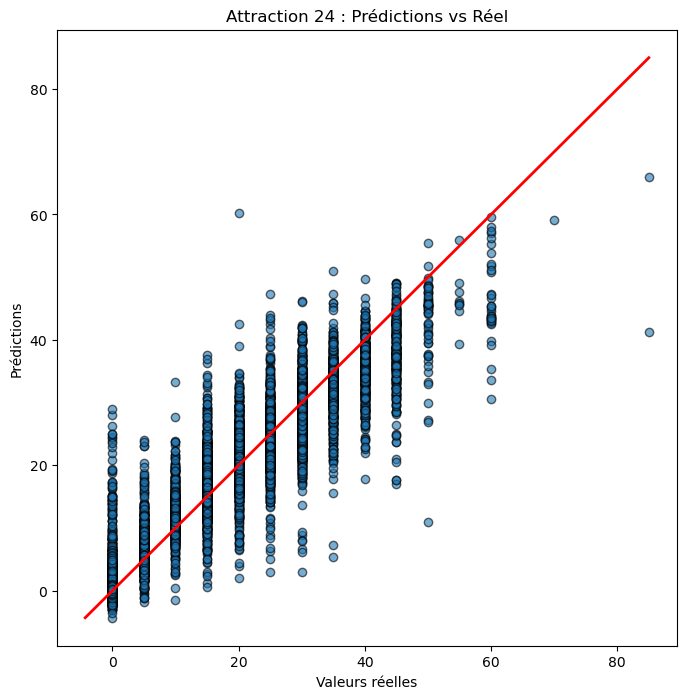

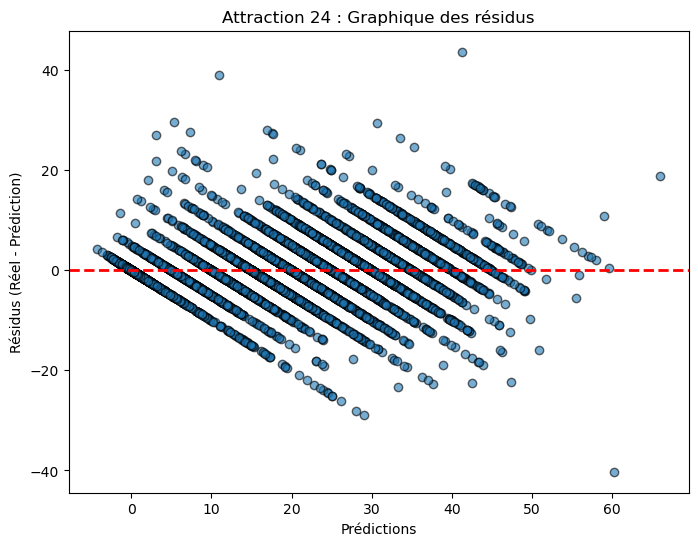

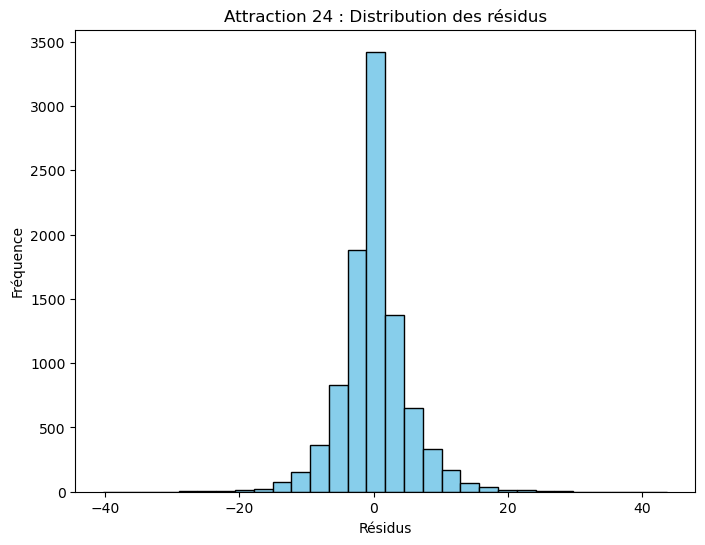

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.108505
Early stopping, best iteration is:
[149]	valid_0's l1: 0.108023
Attraction 12 -> RMSE: 0.45, MAE: 0.11


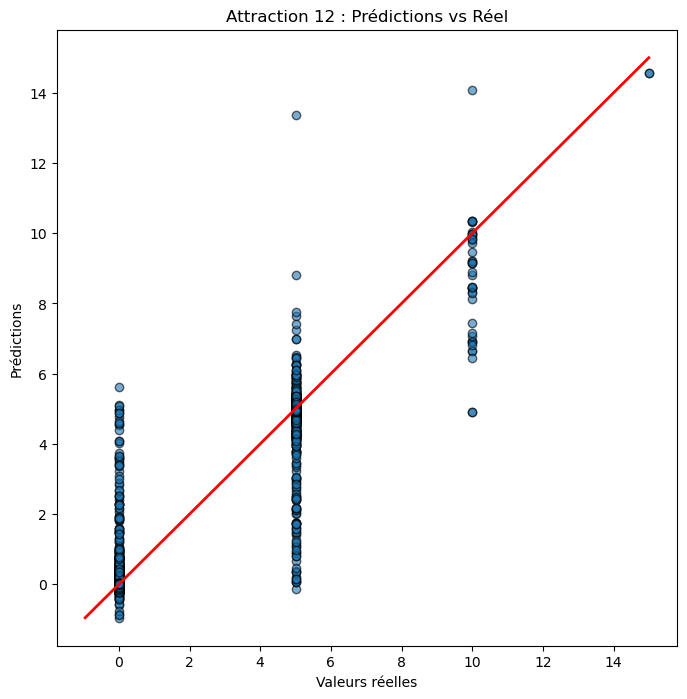

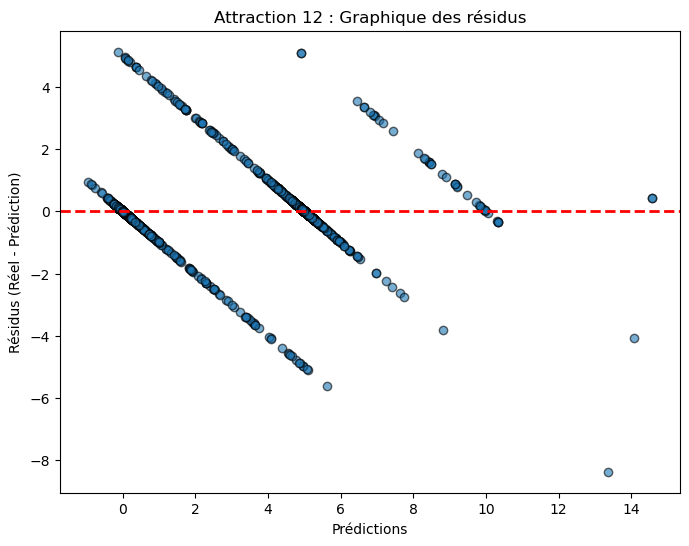

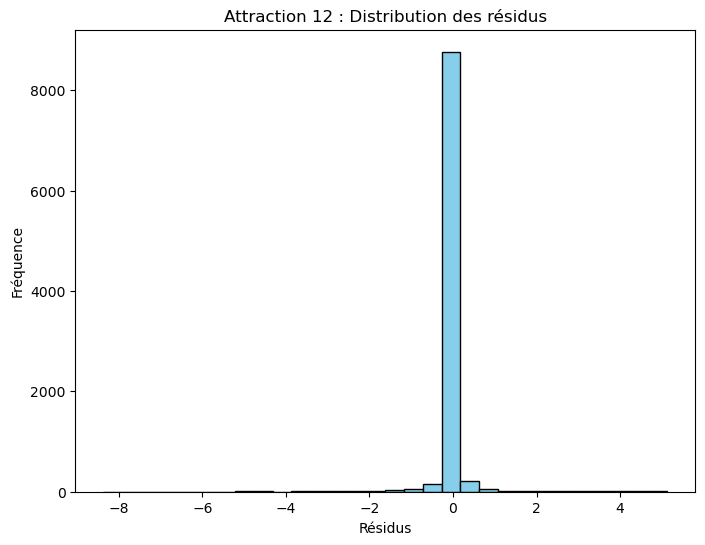

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.805456
Early stopping, best iteration is:
[122]	valid_0's l1: 0.791528
Attraction 23 -> RMSE: 2.27, MAE: 0.79


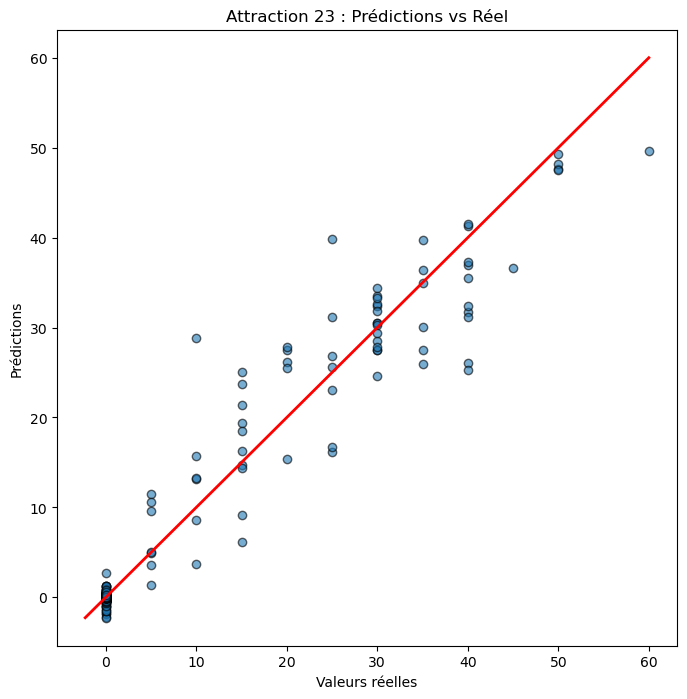

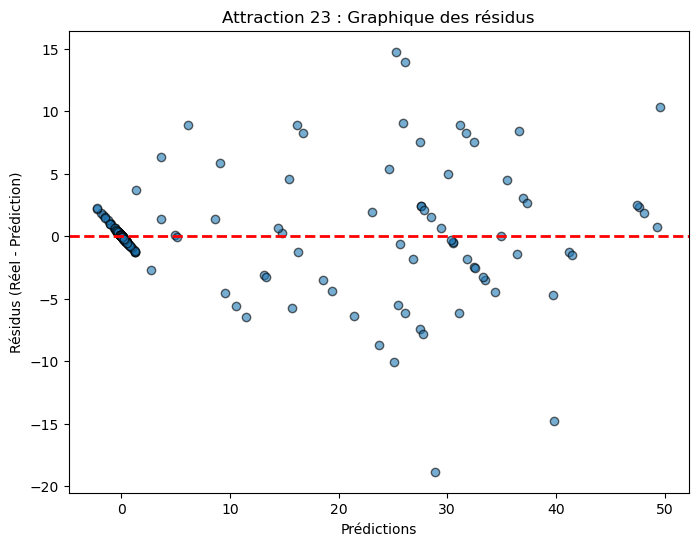

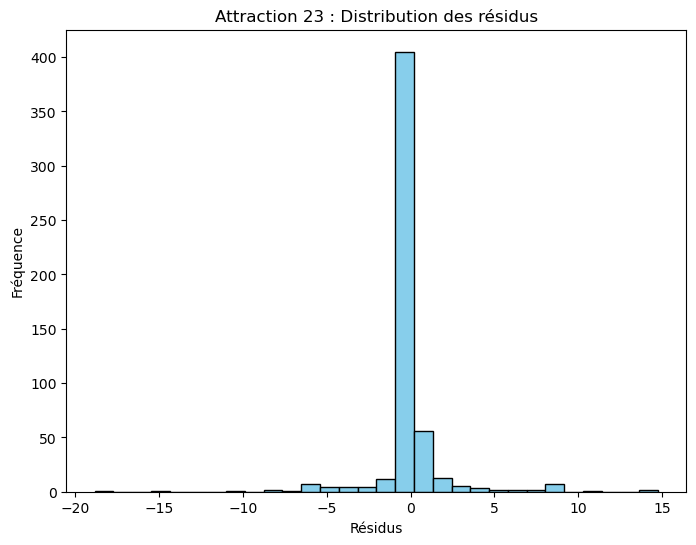

In [ ]:
# On récupère la liste des attractions uniques
entities = df['ENTITY_DESCRIPTION_SHORT'].unique()

for entity in entities:
    # Filtrer les données pour l'attraction en cours
    df_entity = df[df['ENTITY_DESCRIPTION_SHORT'] == entity].copy()
    
    # On ne traite que les entités ayant suffisamment de données
    if len(df_entity) < 50:
        print(f"Skipping entity {entity} (only {len(df_entity)} samples)")
        continue
    
    # Définir les features : retirer la cible et la colonne d'identification
    features = [col for col in df_entity.columns if col not in [target, 'ENTITY_DESCRIPTION_SHORT']]
    
    # Séparer X et y
    X = df_entity[features]
    y = df_entity[target]
    
    # Division en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Création des datasets pour LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data  = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Entraînement du modèle avec early stopping et log via callbacks
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
    )
    
    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    # Calcul optionnel des métriques (affichées dans la console)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    print(f"Attraction {entity} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    
    # ------------------------------
    # 1. Nuage de points : Réel vs Prédictions
    # ------------------------------
    plt.figure(figsize=(8,8))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    # Définir la ligne diagonale de référence
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', lw=2)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Prédictions")
    plt.title(f"Attraction {entity} : Prédictions vs Réel")
    plt.show()
    
    # ------------------------------
    # 2. Graphique des résidus
    # ------------------------------
    residuals = y_test - y_pred
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel("Prédictions")
    plt.ylabel("Résidus (Réel - Prédiction)")
    plt.title(f"Attraction {entity} : Graphique des résidus")
    plt.show()
    
    # ------------------------------
    # 3. Histogramme des résidus
    # ------------------------------
    plt.figure(figsize=(8,6))
    plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("Résidus")
    plt.ylabel("Fréquence")
    plt.title(f"Attraction {entity} : Distribution des résidus")
    plt.show()
